# Cinemagia review dataset


The purpose of this project is to provide an overview of a review-based classification project that predicts the movie's title from a Romanian language dataset.

The dataset used in this project is “Cinemagia movie reviews dataset” - https://www.kaggle.com/datasets/adibadea/cinemagia-movie-reviews-dataset



### **Useful imports**

In [ ]:
!pip install gensim
!pip install pyphen
!pip install pronouncing
!pip install tensorflow-addons
!pip install textstat
!pip install transformers
!pip install pronouncing
!pip install more-itertools
!pip install catboost
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time
import tensorflow as tf
import random
import pandas as pd

import PIL
import os
import matplotlib.pyplot as plt
import cv2
import zipfile
import PIL
import sklearn
import sklearn.metrics
import string
import json
import nltk
import re
import pyphen
import pronouncing
import textstat
import pronouncing
import transformers
import gensim 
import gensim.downloader
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from catboost import CatBoostClassifier
from more_itertools import chunked
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords 
from sklearn.metrics import accuracy_score
from datetime import datetime
from collections import Counter
from transformers import AutoTokenizer, TFAutoModelForCausalLM

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download("punkt")

STEMMER = SnowballStemmer("romanian")
ROMANIAN_STOPWORDS = set(stopwords.words('romanian'))
PUNCTUATION = set(string.punctuation)
SYLLABLES_SPLITTER = pyphen.Pyphen(lang='ro')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### **Data Preprocessing**


The dataset is already split in training and testing. These parts are firstly read into the train_df and test_df with Pandas dataframes and will be shuffled to ensure a random distribution. The resulting data frames will be used for feature extraction. 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH_TRAIN = os.path.join("/content/drive/MyDrive/", "cinemagia-train-dataset.csv")
PATH_TEST = os.path.join("/content/drive/MyDrive/", "cinemagia-test-dataset.csv")

train_df = pd.read_csv(PATH_TRAIN , usecols=["Comment", "Title"], dtype={"Comment": str, "Title": str})
test_df = pd.read_csv(PATH_TEST , usecols=["Comment", "Title"], dtype={"Comment": str, "Title": str})

# Shuffling the data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

# Remove empty comments
train_df = train_df[train_df["Comment"].apply(lambda text: len(text.strip()) > 0)] 
test_df = test_df[test_df["Comment"].apply(lambda text: len(text.strip()) > 0)]

print("Train DataFrame\n")
print(train_df)
print("Test DataFrame\n")
print(test_df)

Train DataFrame

                        Title  \
0                      Avatar   
1                      Avatar   
2          Gone with the wind   
3            Schindler's List   
4                      Avatar   
..                        ...   
646    Hachiko: A Dog's Story   
647                    Avatar   
648                    Avatar   
649           Game of Thrones   
650  The Shawshank Redemption   

                                               Comment  
0    o tampenie SF!.o dezamagire intreg filmu! cam ...  
1    Capodopera.suber filmul cel mai bun sf pana ac...  
2    Gone with the Wind “Pe aripile vintului”.O cap...  
3    "This pin. Two people. This is gold.".Scenariu...  
4    de ce ...?.As putea sa spun ca filmul se mulea...  
..                                                 ...  
646  Bunicel.Faptul ca starneste o emotie, nu-i suf...  
647  spectacol vizual.un real spectacol vizual,pove...  
648  foarte bun!.Bineinteles...gandirea romanului.....  
649  Numai bla b

## Data Visualization

The code below creates a plot to visualize the distribution of the movie comments in the training and test datasets. 

The plot_histogram function creates a bar plot for a given dataframe, grouping the data by the "Title" column and counting the number of comments for each movie title.

The function also sorts the data by the number of comments in descending order, and the resulting bar plot shows the frequency of comments for each movie title. This helps to understand the distribution of the data and provides insight into the data imbalance, if any.

In addition it will be print the distribution of the movie comments in the training and test datasets.


Distribution in the train movie dataset:

                                                    Comment
Title                                                      
Avatar                                                  153
Hachiko: A Dog's Story                                  111
The Shawshank Redemption                                 77
Prison Break                                             71
Schindler's List                                         63
Lord of the rings                                        52
Game of Thrones                                          50
Pirates of the Caribbean: The Curse of the Blac...       36
Gone with the wind                                       20
Harry Potter and the Goblet of Fire                      18
-------------------------------

Distribution in the test movie dataset:

                                                    Comment
Title                                                      
Avatar                                      

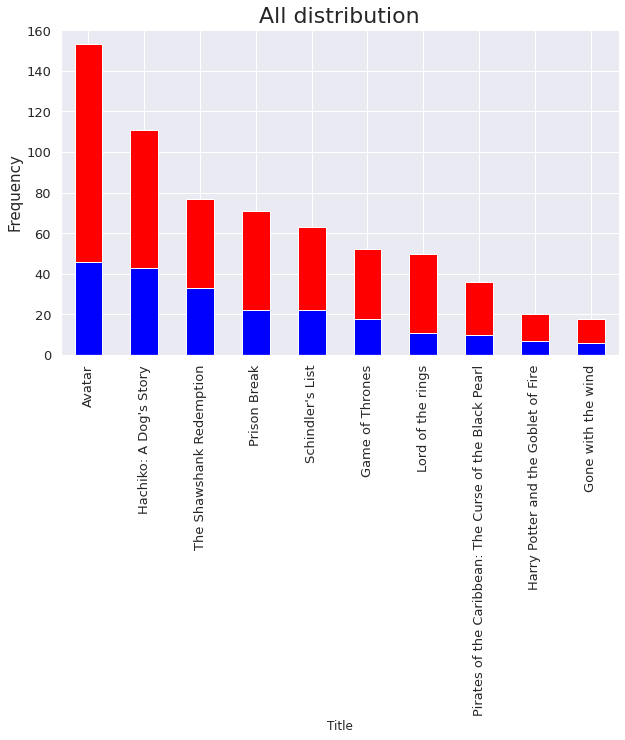

In [ ]:
import seaborn as sns
sns.set_theme()

def plot_histogram(data_frame, title, key, color):
    data_frame = data_frame.groupby(by=[key]).count().sort_values("Comment", ascending=False)["Comment"]
    ax = data_frame.plot(kind='bar', figsize=(10,6), color=color, fontsize=13)
    ax.set_title(title, fontsize=22)
    ax.set_ylabel("Frequency", fontsize=15)


print("Distribution in the train movie dataset:\n")
print(train_df.groupby(by=["Title"]).count().sort_values("Comment", ascending=False))
plot_histogram(data_frame=train_df, title="", key="Title", color="red")
print("-------------------------------\n")

print("Distribution in the test movie dataset:\n")
print(test_df.groupby(by=["Title"]).count().sort_values("Comment", ascending=False))
plot_histogram(data_frame=test_df, title="All distribution", key="Title", color="blue")
print("-------------------------------\n")

## Dataset mapping

In the code below, the movie titles from the training and test datasets are mapped to integers to be used as labels for training and evaluation of the text classification model.

The code first groups the training data by the "Title" column and counts the number of comments for each movie title. The resulting data is then sorted in descending order based on the number of the comments.

The movie titles are then enumerated and stored in a dictionary, with the movie title as the key and its corresponding integer label as the value. This dictionary is then used to map the movie titles in both the training and test datasets to their corresponding integer labels.

Finally, the word "și" word is added to the set of Romanian stopwords, because the NLTK list of romanian stopwords only has the "şi" written version of this word.

In [ ]:
movie_mappings = train_df.groupby(by=["Title"]).count().sort_values("Comment", ascending=False).reset_index()["Title"].tolist()
movie_mappings = {genre: id for id, genre in enumerate(movie_mappings)}

train_df["label"] = train_df["Title"].apply(lambda genre: movie_mappings[genre])
test_df["label"] = test_df["Title"].apply(lambda genre: movie_mappings[genre])

print("The movie titles are: {}".format(movie_mappings))
print("Number of movie titles: {}".format(len(movie_mappings)))
ROMANIAN_STOPWORDS.add("și")

The movie titles are: {'Avatar': 0, "Hachiko: A Dog's Story": 1, 'The Shawshank Redemption': 2, 'Prison Break': 3, "Schindler's List": 4, 'Lord of the rings': 5, 'Game of Thrones': 6, 'Pirates of the Caribbean: The Curse of the Black Pearl': 7, 'Gone with the wind': 8, 'Harry Potter and the Goblet of Fire': 9}
Number of movie titles: 10


The sanitize function is used to preprocess the comments data and prepare it for the sentiment analysis. 

The first step is to convert the text to lowercase, then remove punctuation and other non-relevant symbols. 

Additionally, digits are removed from the text. 

Then, the words are split into a list, and a stemmer is applied to the words if the stem_flag argument is set to True. Stopwords can also be removed if the remove_stopwords argument is set to True. Finally, the words are joined back into a string and returned as the processed text.

In [ ]:
def sanitize(text, stem_flag=False, remove_stopwords=False):
    text = text.lower()

    text = re.sub("[{}]+".format(string.punctuation + string.whitespace), " ", text)
    text = ''.join([i for i in text if not i.isdigit()])

    words = [word for word in text.split(" ") if len(word) > 0]
        
    if stem_flag:
      words = [STEMMER.stem(word) for word in words]
    
    if remove_stopwords:
      words = [word for word in words if word not in ROMANIAN_STOPWORDS] 
    text = " ".join(words)
    return text

The following function `most_frequent_words` takes a list of texts and a title as input and returns a bar chart showing the frequency of the top n words. 


We use CountVectorizer to calculate the bag of words representation and then calculate the frequency of each word. 

The frequencies are sorted in descending order, and the top n words are selected. 

The bar chart is created using matplotlib, with the words being shown on the x-axis and their frequencies on the y-axis. The bar chart is given a title equal to the title parameter.

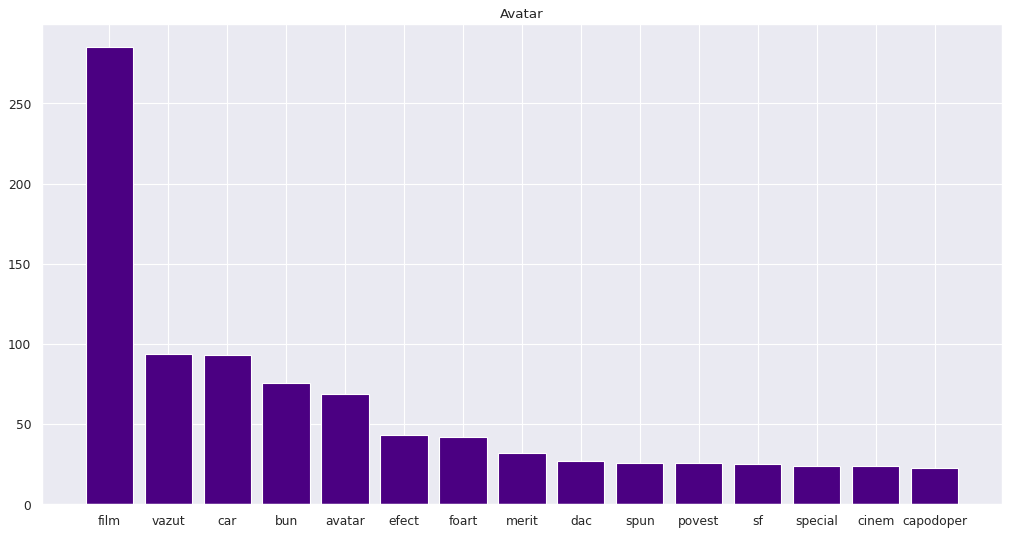

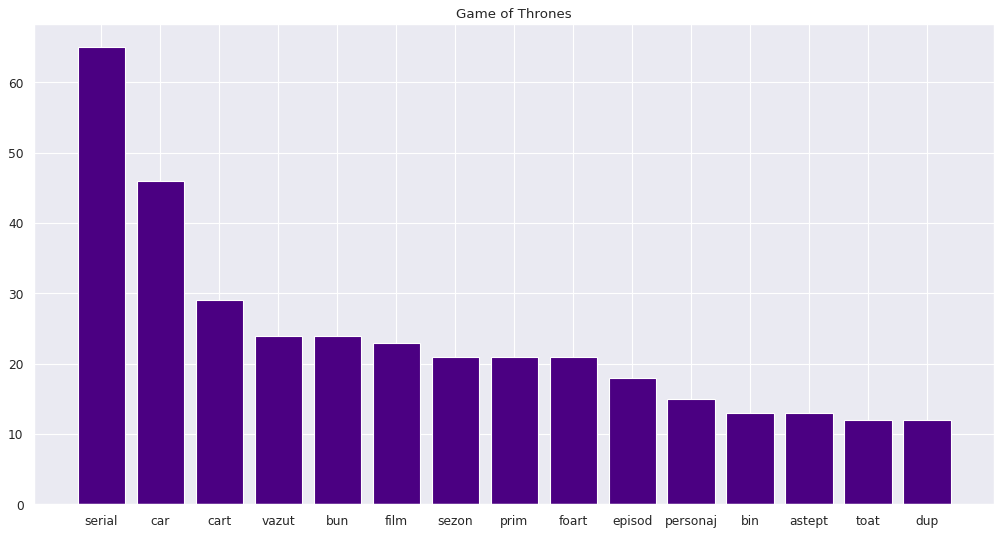

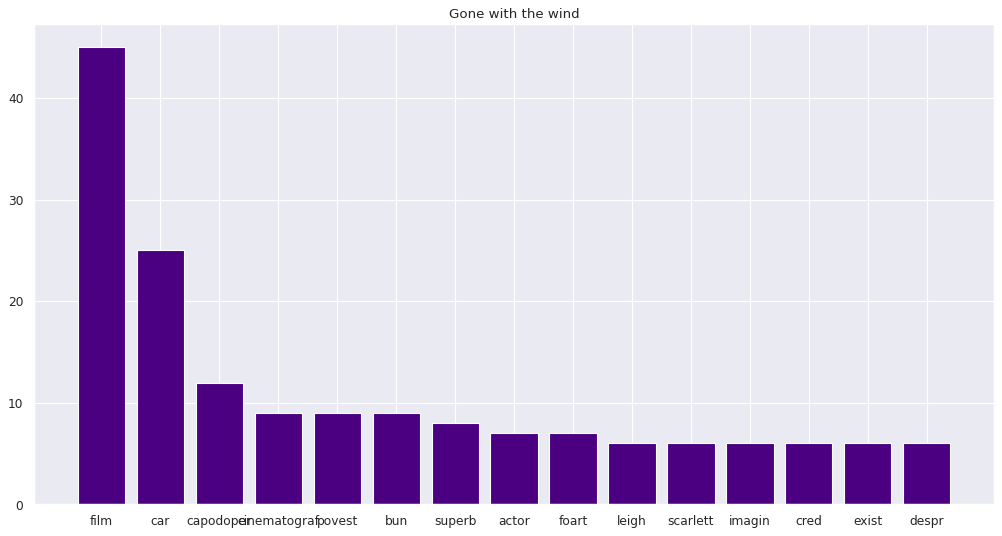

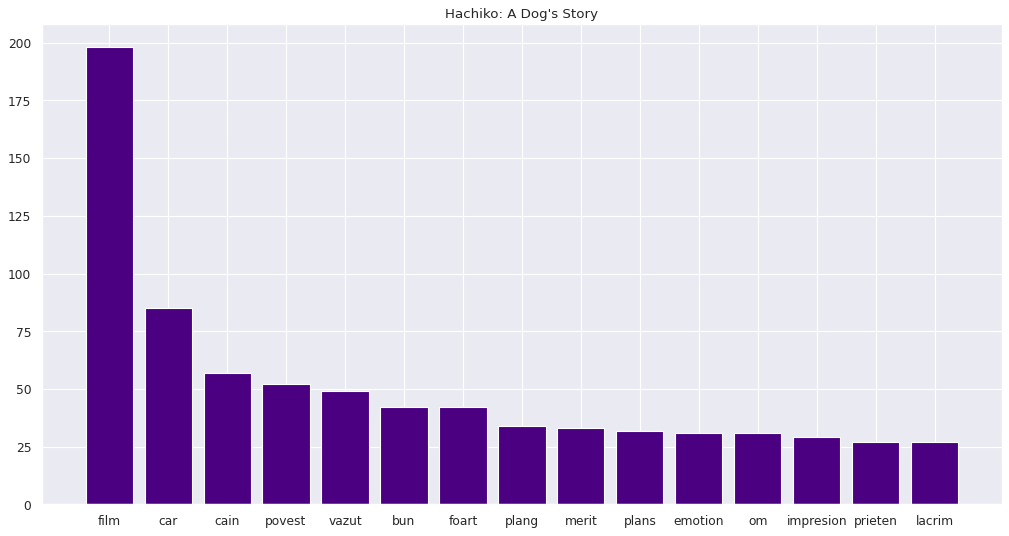

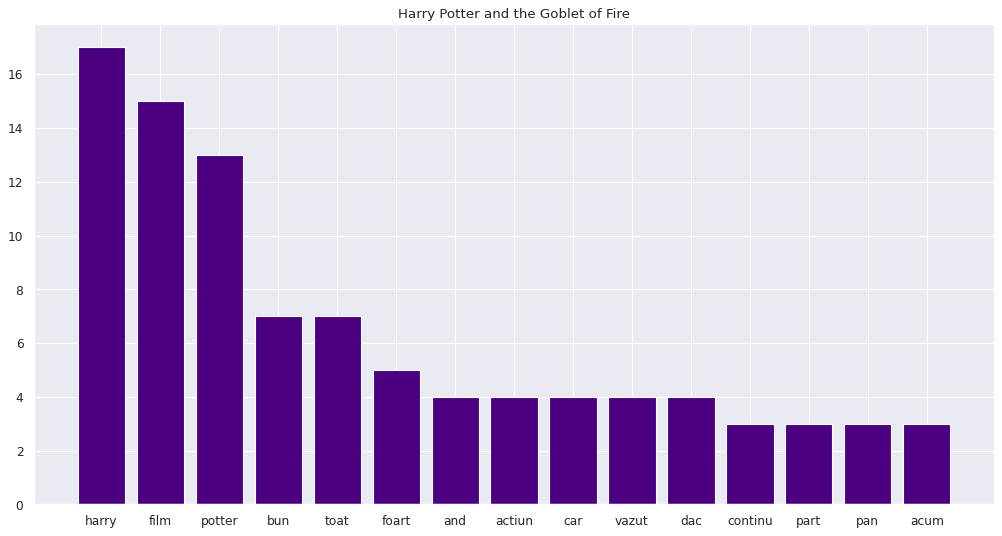

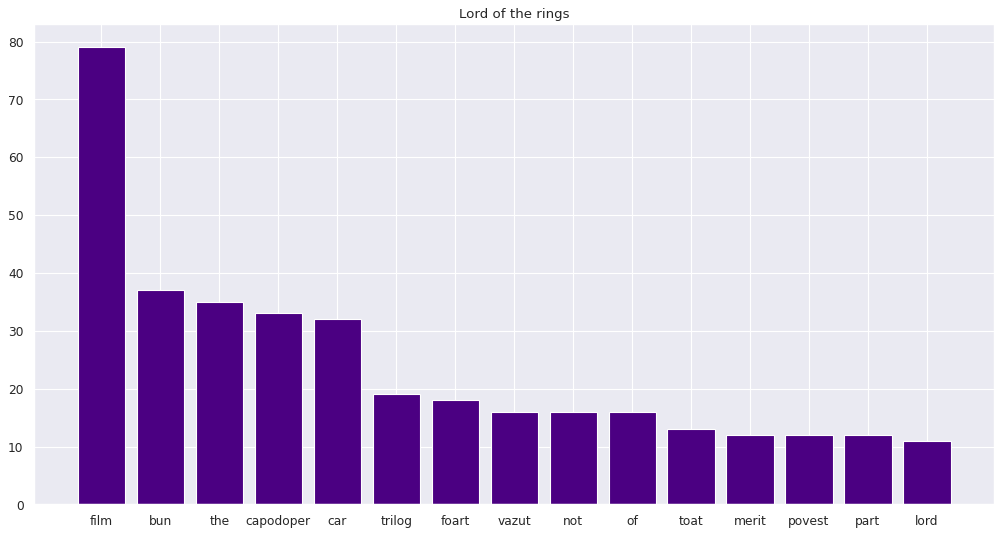

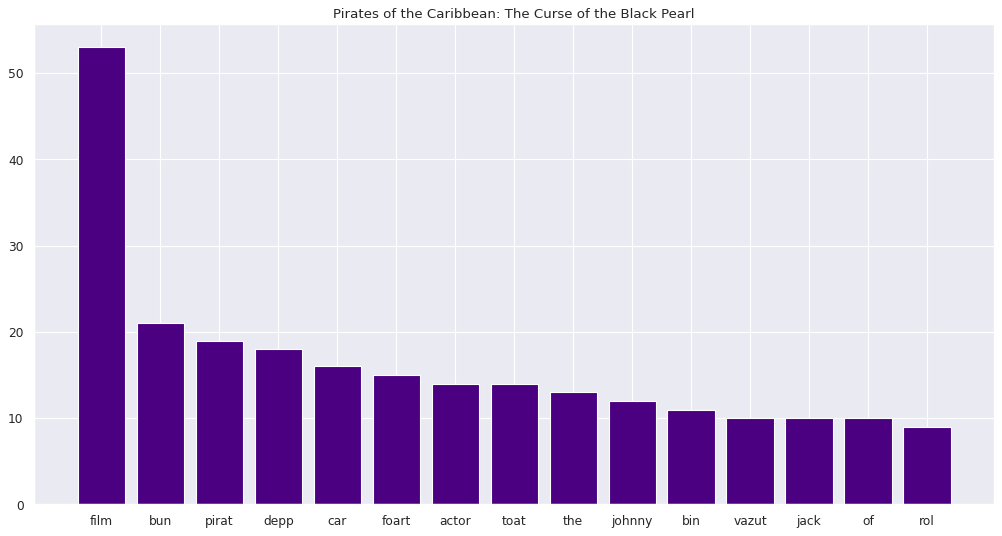

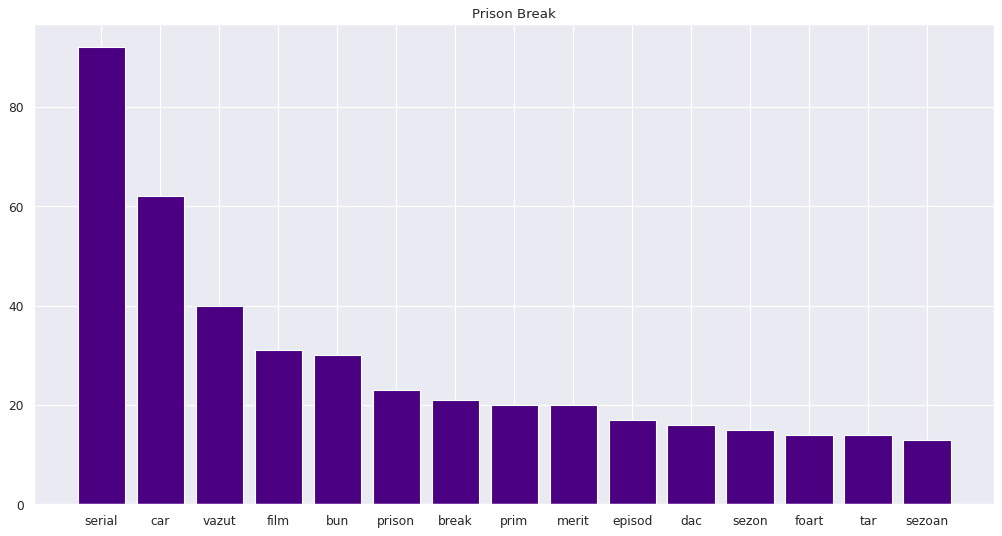

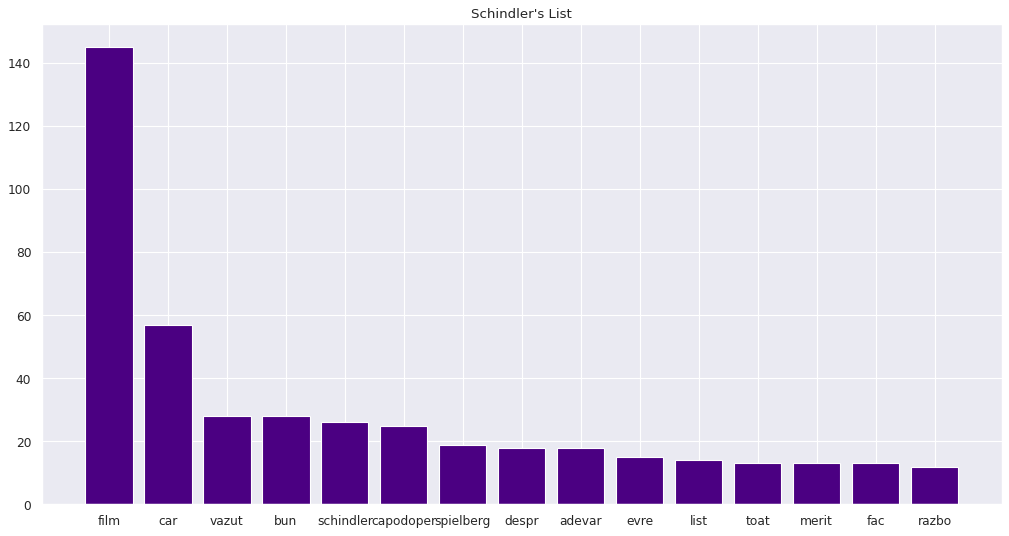

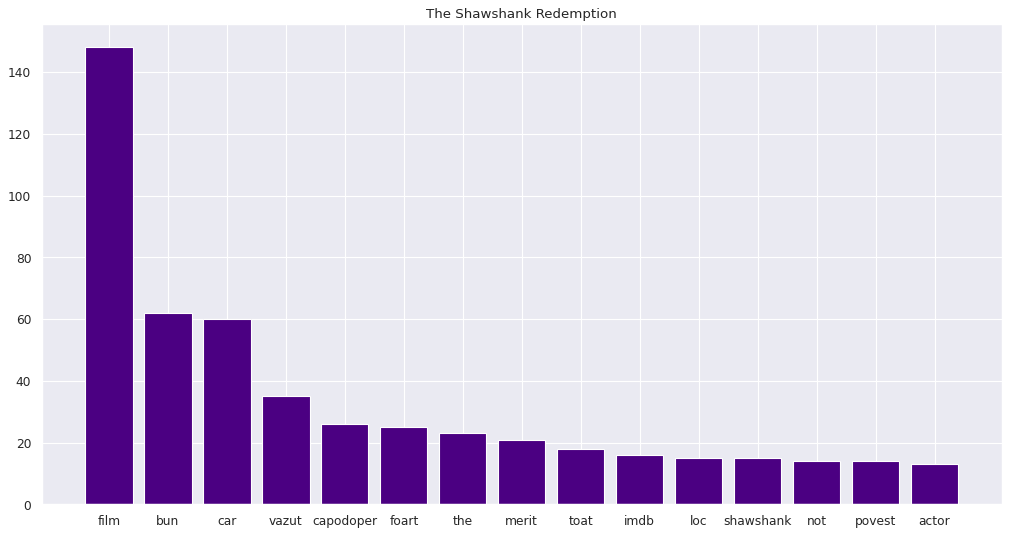

In [ ]:
def most_frequent_words(text, title, top_words=15):
    vectorizer = CountVectorizer()
    bow = vectorizer.fit_transform(text)
    sum_words = bow.sum(axis=0) 
    words_frequency = [(word, sum_words[0, id]) for word, id in vectorizer.vocabulary_.items()]
    words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
    top_words = words_frequency[:top_words]
    fig = plt.figure(figsize=(12, 6), dpi=80)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.bar([x[0] for x in top_words], [x[1] for x in top_words], color="indigo")
    ax.set_title(title)
    plt.show()

grouped_by = train_df.groupby(by="Title")

for movie in grouped_by.groups.keys():
    sanitized_comment = grouped_by.get_group(movie)["Comment"].apply(lambda text: sanitize(text, True, True))
    most_frequent_words(sanitized_comment, top_words=15, title=movie)

Next, we are computing various features of a text input :
We have different functions for:
* Computing the frequency of multiple parts of speech in the text, using the Spacy library  
* Counting the number of stopwords in the text
* Computing various general metrics such as mean, standard deviation, min, max, and quartiles for the number of words, syllables, and letters per comment.


In the `define_text_features` function the features are computed using the following steps:
* Converting the text to lowercase
* Removing any continuous subsequence of special characters and whitespaces
* Splitting the text into words, and removing empty words
* Compiling lists of words, syllables, and letters per comment
* Computing various metrics such as mean, standard deviation, min, max, and quartiles for the number of words, syllables, and letters per comment.
* Using the `compute_pos_frequency` function to compute the frequency of multiple parts of speech in the comments
* Using the `stopwords_count` function to count the number of stopwords in the comments
* Using the `compute_general_metrics` function for computing the overall number of words, letters, and stopwords in the text
* Returning the computed features as a dictionary, unless the "return_type" is set to "list", in which case it returns the features as a list.

The output of the script can be used for various NLP tasks such as text classification, sentiment analysis, and more

In [ ]:
# Downloading spacy models for Romanian POS
!python -m spacy download ro_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 10.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ro_core_news_sm')


In [ ]:
import spacy
from spacy.lang.ro.examples import sentences 
def compute_pos_frequency(comment):
    nlp_ro = spacy.load("ro_core_news_sm")
    pos_tags = nlp_ro(comment.lower())
    frequency = {"CCONJ": 0, "DET": 0, "ADP": 0, "AUX": 0, "ADV": 0, "ADJ": 0, "NUM": 0, "PRON": 0, "NOUN": 0, "SCONJ": 0, "VERB": 0}
    for token in pos_tags:
         if token.pos_ in frequency:
            frequency[token.pos_] += 1
    return frequency

def stopwords_count(comment):
    comment_words = word_tokenize(comment.lower())
    if len(comment_words) == 0:
        return 0, 0
    
    stopwords_number = np.sum([1 for word in comment_words if word in ROMANIAN_STOPWORDS])
    stopwords_number_normalized = stopwords_number / len(comment_words)
    return stopwords_number, stopwords_number_normalized 

def compute_general_metrics(array, name):
    features = {}
    features["avg_{}".format(name)] = np.mean(array)
    features["std_{}".format(name)] = np.std(array)
    features["min_{}".format(name)] = np.min(array)
    features["max_{}".format(name)] = np.max(array)
    features["percentile_25_{}".format(name)] = np.percentile(array, 25)
    features["percentile_50_{}".format(name)] = np.percentile(array, 50)
    features["percentile_75_{}".format(name)] = np.percentile(array, 75)
    return features


def define_text_features(comment, return_type="dict", debug=False):
    start = time.time()

    comment = comment.lower() 
   
    syllables_per_comment, words_per_comment = [], []
    no_syllables_per_comment, no_words_per_comment, no_letters_per_comment = [], [], []
    curated_comment = []
  
    comment = re.sub("[{}]+".format(string.punctuation + string.whitespace), " ", comment) #replacing any continuous subsequence of special characters with a whitespace
    words = [word for word in comment.split(" ") if len(word) > 0] #splitting along whitespaces and remove empty words
    
    syllables_per_comment.append([SYLLABLES_SPLITTER.inserted(word).split("-") for word in words])
    words_per_comment.append(words)
    no_syllables_per_comment.append([len(SYLLABLES_SPLITTER.inserted(word).split("-")) for word in words])
    no_words_per_comment.append(len(words))
    no_letters_per_comment.append(np.sum([len(word) for word in words]))
        
    curated_comment.append(comment)
    
    text_features = {}
    # Words per comment
    text_features.update(compute_general_metrics(no_words_per_comment, "words_per_comment"))

    # Syllables per comment
    syllables_frequency = [np.sum(no_syllables_per_comment) for no_syllables_per_line in no_syllables_per_comment]
    text_features.update(compute_general_metrics(syllables_frequency, "syllables_per_comment"))
    
    # Letters per comment
    text_features.update(compute_general_metrics(no_letters_per_comment, "letters_per_comment"))

    # compute part-of-speech frequencies
    text_features.update(compute_pos_frequency(comment))

    # compute no of stopwords
    text_features["count_stopwords"], text_features["count_stopwords_normalized"] = stopwords_count(comment)

    text_features["number_of_words"] = np.sum(no_words_per_comment)
    text_features["number_of_letters"] = np.sum(no_letters_per_comment)

    # Converting to numpy (sorting the keys())
    if return_type in ("npy", "numpy"):
        text_features = [text_features[key] for key in sorted(text_features)]
    end = time.time()

    if debug:
        print("Elapsed {} seconds".format(end - start))
    
    return text_features

example_comment = train_df["Comment"][111]
print(example_comment)
define_text_features(example_comment, return_type="dict", debug=True)

Nu pot sa cred atata supraapreciere.....Incredibil! Nu filmul, ci supraevaluarea lui... Un scenariu de tot rahatu' jucat de oameni albastri si frumosi (motion capture) intr-o lume computer generated, cu animale sinistre... Interpretari de cacao, subiect datand de pe la triburile incase (ceea ce Omatycaia pipal nu depaseste)... Un film se reduce mai nou la efecte speciale??? Vai de noi!
Elapsed 0.579636812210083 seconds


{'avg_words_per_comment': 61.0,
 'std_words_per_comment': 0.0,
 'min_words_per_comment': 61,
 'max_words_per_comment': 61,
 'percentile_25_words_per_comment': 61.0,
 'percentile_50_words_per_comment': 61.0,
 'percentile_75_words_per_comment': 61.0,
 'avg_syllables_per_comment': 126.0,
 'std_syllables_per_comment': 0.0,
 'min_syllables_per_comment': 126,
 'max_syllables_per_comment': 126,
 'percentile_25_syllables_per_comment': 126.0,
 'percentile_50_syllables_per_comment': 126.0,
 'percentile_75_syllables_per_comment': 126.0,
 'avg_letters_per_comment': 302.0,
 'std_letters_per_comment': 0.0,
 'min_letters_per_comment': 302,
 'max_letters_per_comment': 302,
 'percentile_25_letters_per_comment': 302.0,
 'percentile_50_letters_per_comment': 302.0,
 'percentile_75_letters_per_comment': 302.0,
 'CCONJ': 1,
 'DET': 5,
 'ADP': 11,
 'AUX': 5,
 'ADV': 2,
 'ADJ': 9,
 'NUM': 0,
 'PRON': 4,
 'NOUN': 16,
 'SCONJ': 0,
 'VERB': 2,
 'count_stopwords': 29,
 'count_stopwords_normalized': 0.475409836065

## Data vizualization - PCA

We perform PCA (Principal Component Analysis) visualization on the input data `X` and target data `y`. 

We first scale the input data using the `StandardScaler` from scikit-learn and then performs PCA on the transformed data using the PCA class. 

The scaled and transformed data is then plotted using a scatter plot with the `y` target values used as the color. 

The labels for the legend of the plot are taken from the `movie_mappings` dictionary and sorted based on the value of each key-value pair. 

The plot is finally displayed using `plt.show().`

In [ ]:
def pca_vizualization(X, y):
    print("Vizualization using PCA (with scaler)")
    labels = [k for k, v in sorted(movie_mappings.items(), key=lambda item: item[1])]
    pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])
    X_transformed = pipe.fit_transform(X)
    plot = plt.scatter(X_transformed[:,0], X_transformed[:,1], c=y)
    plt.legend(loc='upper center', bbox_to_anchor=(1.55, 0.9),
          fancybox=True, shadow=True, ncol=1, handles=plot.legend_elements()[0], labels=labels)
    plt.show()

This next code box extracts raw data from train and test sets and stores it in cache to avoid repeated calculations. 

The shapes of the train and test comment and label arrays are printed. 

The `extract_raw_data` function loads the raw data from a file named `raw_data.npz` if it exists, otherwise the data is extracted from the provided `train_df` and `test_df` dataframes and saved in a file named `raw_data.npz` in the cache location specified by the `PATH_TO_CACHE` variable. 

The function returns the raw train and test comments and labels arrays.

In [ ]:
PATH_TO_CACHE = "/content/drive/MyDrive"

def extract_raw_data(train_df, test_df):
    raw_data_path = os.path.join(PATH_TO_CACHE, "raw_data.npz")
    if os.path.isfile(raw_data_path):
        with open(raw_data_path, 'rb') as f:
            d = np.load(f, allow_pickle=True)
            train_labels = d["train_labels"]
            test_labels = d["test_labels"]
            train_comment = d["train_comment"]
            test_comment = d["test_comment"]
    else:
        train_labels, test_labels = np.asarray(train_df["label"]), np.asarray(test_df["label"])
        train_comment, test_comment = np.asarray(train_df["Comment"]), np.asarray(test_df["Comment"])
        with open(raw_data_path, 'wb') as f:
            np.savez(f, train_labels=train_labels, test_labels=test_labels, train_comment=train_comment, test_comment=test_comment)

    return train_comment, train_labels, test_comment, test_labels

train_comment, train_labels, test_comment, test_labels = extract_raw_data(train_df, test_df)
print("Train comments shape: {},  Train labels shape: {}".format(train_comment.shape, train_labels.shape))
print("Test comments shape: {},  Test labels shape: {}".format(test_comment.shape, test_labels.shape))


Train comments shape: (651,),  Train labels shape: (651,)
Test comments shape: (218,),  Test labels shape: (218,)


### *Feature extraction*



This section of the code is responsible for computing the features for the train and test sets. 

Firstly, the function `extract_features` checks if a pre-computed feature file exists in the cache location. If it does, the function loads the pre-computed features, otherwise it computes the features by calling the `define_text_features` function. 

The computed features are saved in the cache location to be loaded later.

After the features have been extracted, the code standardizes the data by scaling the features with a StandardScaler. 

The standardized data is then used to generate a PCA visualization of the features and the corresponding labels with the help of the function `pca_vizualization`. 

This visualization helps to see how the features are distributed and how well they can differentiate the classes.

Train  features shape: (651, 36)
Test  features shape: (218, 36)
Vizualization using PCA (with scaler)


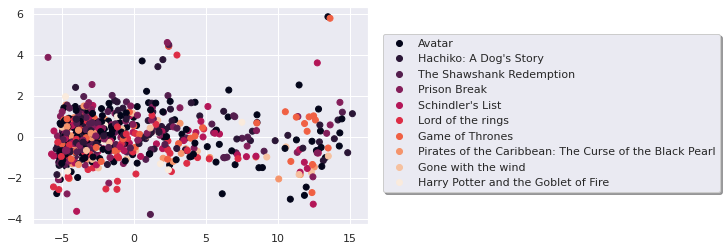

In [ ]:
def extract_features(train_comment, test_comment):
    filename = "extracted_features.npz"
    if os.path.isfile(os.path.join(PATH_TO_CACHE, filename)):
        with open(os.path.join(PATH_TO_CACHE, filename), 'rb') as f:
            d = np.load(f, allow_pickle=True)
            train_features = d["train"]
            test_features = d["test"]
    else:
        train_features = np.asarray([define_text_features(text, return_type="numpy") for text in train_comment])
        test_features = np.asarray([define_text_features(text, return_type="numpy") for text in test_comment])
        with open(os.path.join(PATH_TO_CACHE, filename), 'wb') as f:
            np.savez(f, train=train_features, test=test_features)
    return train_features, test_features

train_features, test_features = extract_features(train_comment, test_comment)

#Standardizing the data
scaler = StandardScaler().fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)
print("Train  features shape: {}".format(train_features.shape))
print("Test  features shape: {}".format(test_features.shape))
# Apply PCA vizualization
pca_vizualization(train_features, train_labels)

### *Create BOW Features (with caching capability)*

This section of code is about extracting and processing the bag of words (BOW) features from the training and test data. 

The BOW features are a representation of the text data, where each feature represents the count of the number of times a specific word appears in the text.

The code first checks if the BOW features have already been extracted and stored in the cache directory. 

If they have, it loads the pre-computed features from the cache. If not, the code starts by sanitizing the text data in the training and test sets by applying stemming (reducing words to their base form) and removing stopwords. 

Then, it uses the `TfidfVectorizer` to vectorize the sanitized text data into BOW features. 

The `TfidfVectorizer` uses the Term Frequency-Inverse Document Frequency (TF-IDF) method to compute the weight of each word in the text, which helps to reduce the impact of common words in the data. 

The vectorizer is configured to use unigrams (i.e., single words), to have a maximum of 1000 features, and to analyze "words".

The extracted BOW features are then stored in the cache for later use. Finally, the code returns the BOW features for the training and test sets, and applies PCA visualization on the training set to visualize the distribution of the data in lower dimensions.

Train tfidf features shape: (651, 1000)
Test tfidf features shape: (218, 1000)
Vizualization using PCA (with scaler)


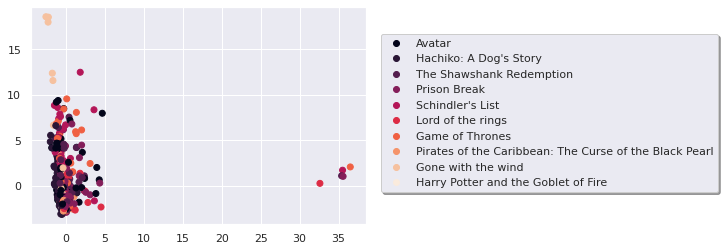

In [ ]:
def extract_bow_features(train_comment, test_comment):
    bow_path = os.path.join(PATH_TO_CACHE, "bow_features.npz")
    STEM_FLAG = True
    REMOVE_STOPWORDS = True

    if os.path.isfile(bow_path):
        with open(bow_path, 'rb') as f:
            d = np.load(f, allow_pickle=True)
            train_tfidf_features = d["train"]
            test_tfidf_features = d["test"]
    else:
        train_sanitized_comment = [sanitize(text, stem_flag=STEM_FLAG, remove_stopwords=REMOVE_STOPWORDS) for text in train_comment]
        test_sanitized_comment = [sanitize(text, stem_flag=STEM_FLAG, remove_stopwords=REMOVE_STOPWORDS) for text in test_comment]
        
        vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=1000, analyzer="word")
        
        train_tfidf_features = vectorizer.fit_transform(train_sanitized_comment).toarray()
        test_tfidf_features = vectorizer.transform(test_sanitized_comment).toarray()
        with open(bow_path, 'wb') as f:
            np.savez(f, train=train_tfidf_features, test=test_tfidf_features)

    return train_tfidf_features, test_tfidf_features

train_tfidf_features, test_tfidf_features = extract_bow_features(train_comment, test_comment)
print("Train tfidf features shape: {}".format(train_tfidf_features.shape))
print("Test tfidf features shape: {}".format(test_tfidf_features.shape))
pca_vizualization(train_tfidf_features, train_labels)

### *Dense Representation from pre-trained transformer (with caching capability)*

This code uses the `SentenceTransformer` module from the sentence-transformers library to generate dense representation features for the training and testing comments. The `extract_dense_representation` function takes in two arguments, the training comments and testing comments, and returns their dense representation features. The code first checks if the dense representation features are already saved in a file, and if they are, it loads them. If they're not, the code first sanitizes the comments, then uses the `dr_model` to encode the comments into dense representation features, which are saved to a file for later use. Finally, the function returns the dense representation features for the training and testing comments, and the shapes of the features are printed. The last line of code calls the `pca_vizualization` function, which takes in the dense representation features and the training labels, but the implementation of this function is not shown in this code snippet.

Train dense representation (transformer) features shape: (651, 384)
Test dense representation (transformer) features shape: (218, 384)
Vizualization using PCA (with scaler)


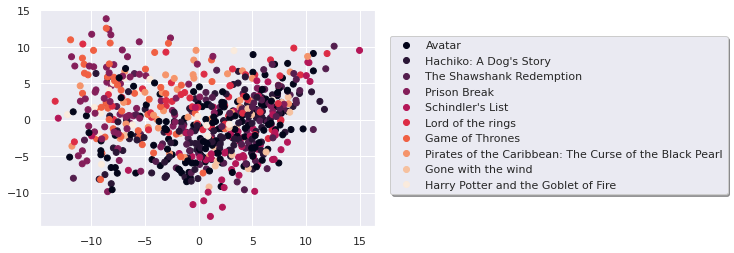

In [ ]:
from transformers import AutoModel, AutoTokenizer, TFAutoModel
def extract_dense_representation(train_comment, test_comment):
    dense_representation_path = os.path.join(PATH_TO_CACHE, "dense_representation_features.npz" ) 
    STEM_FLAG = False 
    REMOVE_STOPWORDS = False 

    if os.path.isfile(dense_representation_path):
        with open(dense_representation_path, 'rb') as f:
            d = np.load(f, allow_pickle=True)
            train_dense_representation_features = d["train"]
            test_dense_representation_features = d["test"]
            
    else:
        dr_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')   

        train_sanitized_comment = [sanitize(text, stem_flag=STEM_FLAG, remove_stopwords=REMOVE_STOPWORDS) for text in train_comment]
        test_sanitized_comment = [sanitize(text, stem_flag=STEM_FLAG, remove_stopwords=REMOVE_STOPWORDS) for text in test_comment]
       
        train_dense_representation_features = np.asarray(dr_model.encode(train_sanitized_comment))
        test_dense_representation_features = np.asarray(dr_model.encode(test_sanitized_comment))

        with open(dense_representation_path, 'wb') as f:
            np.savez(f, train=train_dense_representation_features, test=test_dense_representation_features)
    
    return train_dense_representation_features, test_dense_representation_features

train_dense_representation_features, test_dense_representation_features = extract_dense_representation(train_comment, test_comment)
print("Train dense representation (transformer) features shape: {}".format(train_dense_representation_features.shape))
print("Test dense representation (transformer) features shape: {}".format(test_dense_representation_features.shape))
pca_vizualization(train_dense_representation_features, train_labels)

**Fast Text Representation**


This section is a function to extract the fasttext representation of the text data. The function first checks if the fasttext representation has already been computed and stored in a file named "fasttext_features.npz". If it has, the stored representation is loaded. If it hasn't, the fasttext representation is computed. The input data, train_comment and test_comment, are first sanitized (text cleaning) with the "sanitize" function. Then, the "compute_sentence_embedding" function is applied to each text in the sanitized data to compute the fasttext representation. The fasttext representation is computed by computing the average embedding of each word in the text. If a word is not in the Fasttext model's vocabulary, it is ignored. The fasttext representation of the entire text is stored in train_fasttext_features and test_fasttext_features and returned. The shapes of these arrays are printed for reference.

Train FastText features shape: (651, 300)
Test FastText features shape: (218, 300)
Vizualization using PCA (with scaler)


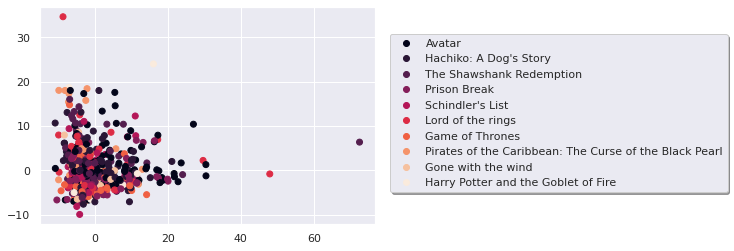

In [ ]:
fasttext_filename = "fasttext_features.npz"

def compute_sentence_embedding(fasttext, text):
    text = sanitize(text.lower())
    words = [word for word in text.split() if len(word) > 0]
    embedding_list = []
    default_embedding = np.zeros(fasttext.vector_size)
    for word in words:
        try:
            embedding = fasttext[word] 
            embedding_list.append(embedding)
        except:
            pass
    if len(embedding_list) == 0:
        return default_embedding
    return np.mean(embedding_list, axis=0)

def extract_fasttext_representation(train_comment, test_comment):
    fasttext_filename = "fasttext_features.npz"
    STEM_FLAG = False # <--- dont apply a stem (as Fasttext can distinguish small modifications)
    REMOVE_STOPWORDS = True # <--- remove stop words as they dont provide useful information when averaging

    if os.path.isfile(os.path.join(PATH_TO_CACHE, fasttext_filename)):
        with open(os.path.join(PATH_TO_CACHE, fasttext_filename), 'rb') as f:
            d = np.load(f, allow_pickle=True)
            train_fasttext_features = d["train"]
            test_fasttext_features = d["test"]
    else:
        fasttext = gensim.downloader.load("fasttext-wiki-news-subwords-300")
        train_sanitized_comment = [sanitize(text, stem_flag=STEM_FLAG, remove_stopwords=REMOVE_STOPWORDS) for text in train_comment]
        test_sanitized_comment = [sanitize(text, stem_flag=STEM_FLAG, remove_stopwords=REMOVE_STOPWORDS) for text in test_comment]

        train_fasttext_features = np.asarray([compute_sentence_embedding(fasttext, text) for text in train_sanitized_comment])
        test_fasttext_features = np.asarray([compute_sentence_embedding(fasttext, text) for text in test_sanitized_comment])
        with open(os.path.join(PATH_TO_CACHE, fasttext_filename), 'wb') as f:
            np.savez(f, train=train_fasttext_features, test=test_fasttext_features)

    return train_fasttext_features, test_fasttext_features
train_fasttext_features, test_fasttext_features = extract_fasttext_representation(train_comment, test_comment)
print("Train FastText features shape: {}".format(train_fasttext_features.shape))
print("Test FastText features shape: {}".format(test_fasttext_features.shape))
pca_vizualization(train_fasttext_features, train_labels)

### *Aggregate Multiple Features Types*

In the next part we concatenate the features obtained from three different feature extraction methods (train_features, train_tfidf_features, and train_dense_representation_features) along the first axis to obtain the combined train_all_features.

The same is done for the test data to obtain test_all_features. 

Then, the shapes of the train and test combined features are printed and a visualization is performed using pca_vizualization function.

Train combined features shape: (651, 1420)
Test combined features shape: (218, 1420)

Vizualization using PCA (with scaler)


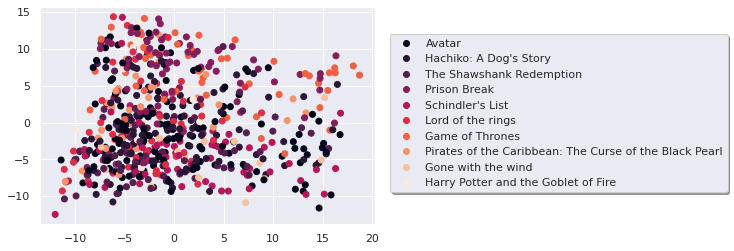

In [ ]:
train_all_features = np.concatenate((train_features, train_tfidf_features, train_dense_representation_features), axis=1)
test_all_features = np.concatenate((test_features, test_tfidf_features, test_dense_representation_features), axis=1)
print("Train combined features shape: {}".format(train_all_features.shape))
print("Test combined features shape: {}".format(test_all_features.shape))
print()
pca_vizualization(train_all_features, train_labels)


# **Modelling Utils**

Plot barchart function

This function is used to plot a custom bar chart. It takes five parameters:
- keys: the labels or names for the bar chart.
- values: the values for each bar in the chart.
- title: the title for the bar chart.
- colors: the colors for each bar. If not specified, default colors are assigned.
- fig_size: the size of the chart.


Train_with_crossvalidation: This function is used to train a machine learning model using cross-validation. It needs the following parameters:
- train_data: the training data used to fit the model.
- train_labels: the labels for the training data.
- test_data: the test data used to evaluate the model's performance.
- test_labels: the labels for the test data.
- name: the name of the model.
- performance_dict: a dictionary to store the accuracy of the model.
- class_name: the class of the model.
- parameters: a dictionary of parameters for the model.
- predict_func: a function to make predictions using the model.
- no_folds: the number of folds to be used in cross-validation.
- print_confusion_matrix: a flag to indicate whether to print the confusion matrix.

The function trains the model using cross-validation by splitting the training data into several folds, training the model on each fold, and evaluating its performance on a validation set. The final performance of the model is calculated as the average accuracy of all folds. If the flag print_confusion_matrix is set to True, a confusion matrix for the test set is printed.

In [ ]:
PERFORMANCE = {}

# Custom plot chart based on key-values
def plot_barchart_custom(keys, values, title, colors=None, fig_size=(12, 7)):
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = fig_size
    ax = fig.add_axes([0, 0, 1, 1])
    if colors is None:
        colors = ['red', 'green', 'blue', "indigo", "cyan", "black", "m", "y", "c", "tab:brown"]
    
    values = np.asarray(values)
    ax.bar(keys, values, color=colors[:len(keys)])
    ax.set_title(title)
    for i in range(len(keys)):
        plt.text(i, values[i] + 0.5, values[i]) 
    plt.show()

# Perform cross_validation using a set of train (which will be split into train + val internally) + a final test set.
# The model to be used, as well as its parameters are given as parameters to this function.
def train_with_crossvalidation(train_data, train_labels, test_data, test_labels, 
                               name, performance_dict,
                               class_name=None, parameters=None, predict_func=None, no_folds=5, print_confusion_matrix=False):
    assert (class_name is not None) ^ (predict_func is not None)
    if parameters is None:
        parameters = {}

    print("##### Cross validation on {} #####\n".format(name))
    kfold = KFold(n_splits=no_folds)
    accuracy_list = []
    # Split into folds
    for train_indices, validation_indices in kfold.split(train_data):
        # Load the corresponding data
        X_train, X_validation = train_data[train_indices], train_data[validation_indices]
        y_train, y_validation = train_labels[train_indices], train_labels[validation_indices]
        X_test, y_test = test_data, test_labels
        
        # Instantiate the class with the passed parameters
        if class_name is not None:  
            model = class_name(**parameters)
            try:
                model.fit(X_train, y_train, verbose=False)
            except:
                model.fit(X_train, y_train)
            # pass the predict function
            predict_func = model.predict

        train_predicted = predict_func(X_train)
        validation_predicted = predict_func(X_validation)
        test_predicted = predict_func(X_test)

        accuracy_train = accuracy_score(y_train, train_predicted)
        accuracy_validation = accuracy_score(y_validation, validation_predicted)
        accuracy_test = accuracy_score(y_test, test_predicted)
        
        print("###################\n")
        print("#### [Train] Accuracy: {}%".format(accuracy_train * 100.0))
        print("#### [Validation] Accuracy: {}%".format(accuracy_validation * 100.0))
        print("#### [Test] Accuracy: {}%".format(accuracy_test * 100.0))
        print("###################\n")
        accuracy_list.append(accuracy_test * 100)
    performance_dict[name] = round(np.mean(accuracy_list), 2)

    # Print the confusion matrix
    if print_confusion_matrix:
        labels = [k for k, v in sorted(movie_mappings.items(), key=lambda item: item[1])]
        cm = confusion_matrix(y_test, test_predicted, normalize="all")
        cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_title("#### Confusion Matrix Normalized for {} ####\n".format(name))
        cmp.plot(ax=ax)
    
    print("-----------------------------------------\n")
    return accuracy_list

This code is for a function `perform_exhaustive_training` that performs training on multiple machine learning models (SVM, CatBoost, Logistic Regression, Random Forest) and records the results of cross-validation. The function takes several inputs such as train data, train labels, test data, test labels, features type, and number of folds for cross-validation (default is 5). The results are stored in the dictionary `performance`. The models are trained using the `train_with_crossvalidation` function and different parameters for each model. The function plots a bar chart of the models' performance based on the `performance` dictionary and returns the dictionary.

In [ ]:
# Function used to perform training on multiple models and recording the result from the cross-validation.
def perform_exhaustive_training(train_data, train_labels, test_data, test_labels, features_type, no_folds=5, print_confusion_matrix=False):
    performance = {}
    class_weights = None
    
    ### SVM ###
    parameters_svm = {"class_weight": class_weights}
    train_with_crossvalidation(train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels,
                               class_name=SVC,
                               parameters=parameters_svm,
                               no_folds=no_folds,
                               name="SVM_{}_features".format(features_type), performance_dict=performance,
                               print_confusion_matrix=print_confusion_matrix)
    ### CatBoost ###
    parameters_catboost = {"iterations": 1000,
                           "task_type": "GPU",
                           "devices": '0',
                           "auto_class_weights": class_weights
                           }
    train_with_crossvalidation(train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels,
                               class_name=CatBoostClassifier,
                               parameters=parameters_catboost,
                               no_folds=no_folds,
                               name="CatBoost_{}_features".format(features_type), performance_dict=performance,
                               print_confusion_matrix=print_confusion_matrix)
    ### LogisticRegression ###
    parameters_logistic_regression = {"max_iter": 1000, "class_weight": class_weights}
    train_with_crossvalidation(train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels,
                               class_name=LogisticRegression,
                               parameters=parameters_logistic_regression,
                               no_folds=no_folds,
                               name="LogisticRegression_{}_features".format(features_type), performance_dict=performance,
                               print_confusion_matrix=print_confusion_matrix)
    ### RandomForest ###
    parameters_randomforest = {"class_weight": class_weights}
    train_with_crossvalidation(train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels,
                               class_name=RandomForestClassifier,
                               parameters=parameters_randomforest,
                               no_folds=no_folds,
                               name="RandomForest_{}_features".format(features_type), performance_dict=performance,
                               print_confusion_matrix=print_confusion_matrix)

    # Plot the performance of the these models
    performance = {k: v for k, v in sorted(performance.items(), key=lambda item: item[1])}
    keys = [key.split("_")[0] for key in performance.keys()]
    values = list(performance.values())
    plot_barchart_custom(keys, values, title="Feature Type: {}".format(features_type))

    return performance


# **Shallow models**

In [ ]:
NO_FOLDS = 3
PRINT_CONFUSION_MATRIX = True

## *Using Basic Text Features*

This code block is a call to a function "perform_exhaustive_training", which trains and evaluates four machine learning models (Support Vector Machines, Catboost, Logistic Regression and Random Forest) using cross-validation. 

The function is passed training and testing data and labels, a feature type of "Text", the number of folds in cross-validation (NO_FOLDS), and a flag to print the confusion matrix (PRINT_CONFUSION_MATRIX). 

The performance of the four models is recorded and stored in the "performance" dictionary. 

Finally, the "performance" dictionary is updated with the results from this call to "perform_exhaustive_training".

On one iteration results showed that Logistic Regression has 22.02% accuracy, followed by SVM with 21.25%, Catboost with 19.57%, and Random Forrest with 16.82%.

##### Cross validation on SVM_Text_features #####

###################

#### [Train] Accuracy: 27.188940092165897%
#### [Validation] Accuracy: 27.188940092165897%
#### [Test] Accuracy: 21.100917431192663%
###################

###################

#### [Train] Accuracy: 29.493087557603687%
#### [Validation] Accuracy: 21.658986175115206%
#### [Test] Accuracy: 20.18348623853211%
###################

###################

#### [Train] Accuracy: 26.95852534562212%
#### [Validation] Accuracy: 20.737327188940093%
#### [Test] Accuracy: 19.724770642201836%
###################

-----------------------------------------

##### Cross validation on CatBoost_Text_features #####

###################

#### [Train] Accuracy: 99.76958525345621%
#### [Validation] Accuracy: 24.88479262672811%
#### [Test] Accuracy: 20.642201834862387%
###################

###################

#### [Train] Accuracy: 100.0%
#### [Validation] Accuracy: 23.963133640552993%
#### [Test] Accuracy: 18.807339449541285%
#############

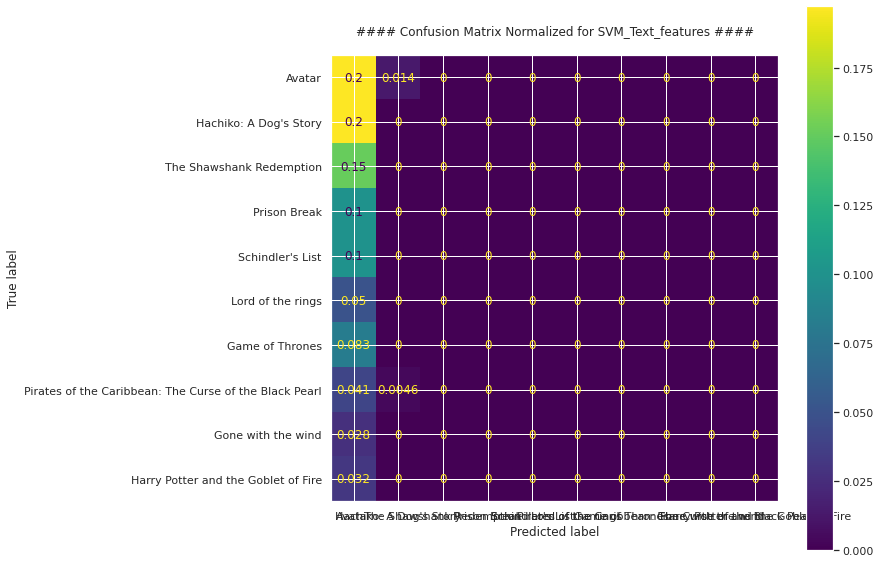

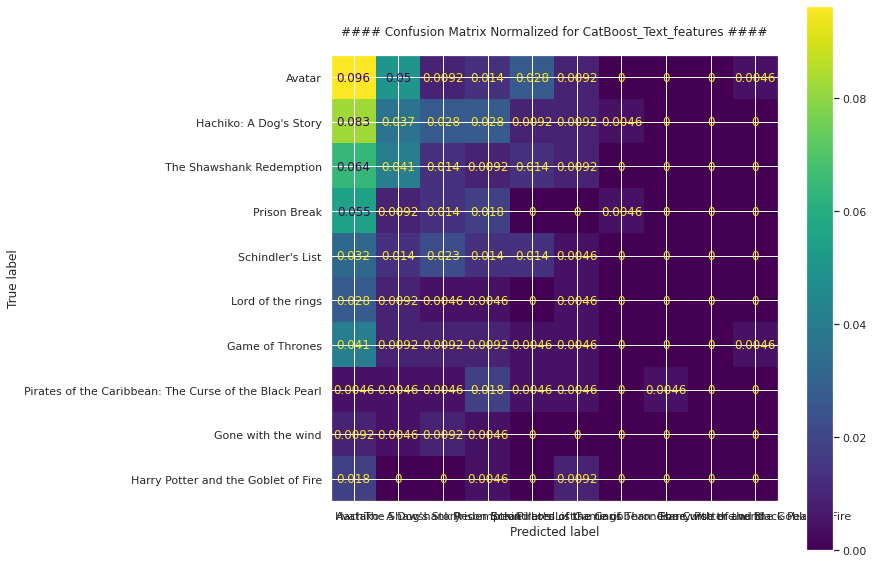

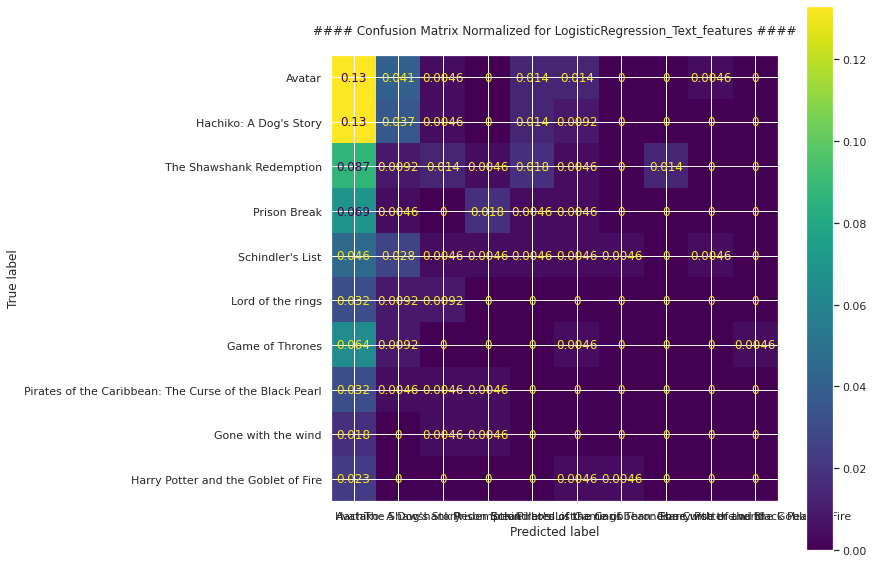

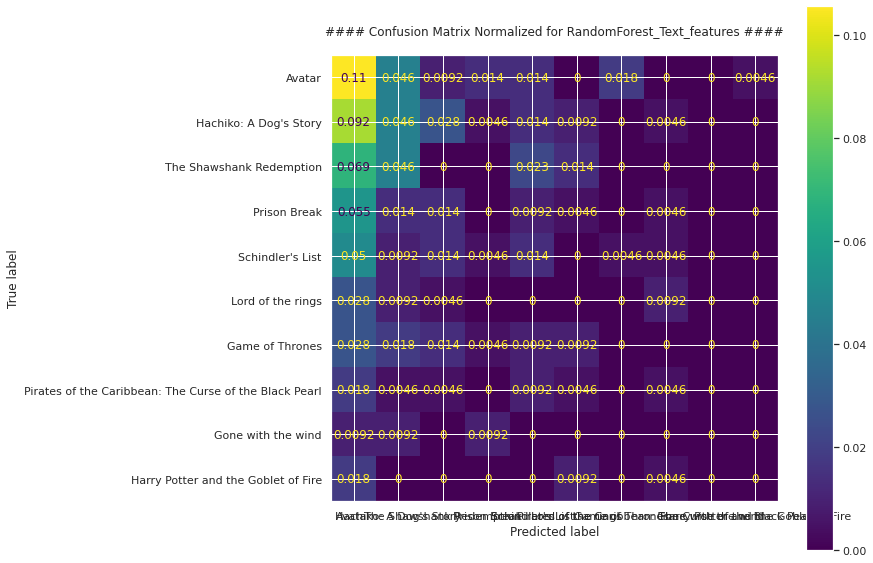

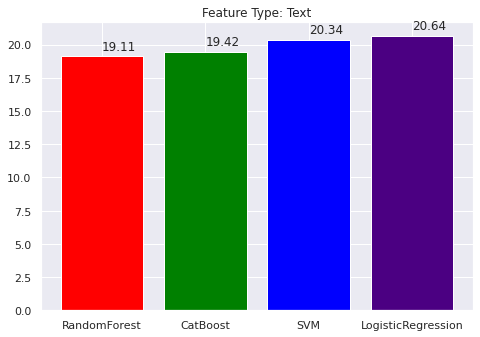

In [ ]:
performance = perform_exhaustive_training(train_data=train_features, train_labels=train_labels, test_data=test_features, test_labels=test_labels, features_type="Text", no_folds=NO_FOLDS, print_confusion_matrix=PRINT_CONFUSION_MATRIX)
PERFORMANCE.update(performance)

## *Bag of Words (TF-IDF)*

The section performs training on multiple models (Logistic Regression, SVM, Catboost, and Random Forest) using TF-IDF features and records the performance from the cross-validation. 

The performance of each model is then stored in a dictionary performance which updates the global dictionary PERFORMANCE. The accuracy of the models is shown in the following order: Random Forest had 66.21% accuracy, Catboost was 61.62%, Logistic Regression was 61.31% and SVM was 55.2%.

##### Cross validation on SVM_tfidf_features #####

###################

#### [Train] Accuracy: 97.6958525345622%
#### [Validation] Accuracy: 56.68202764976959%
#### [Test] Accuracy: 55.5045871559633%
###################

###################

#### [Train] Accuracy: 99.30875576036865%
#### [Validation] Accuracy: 50.69124423963134%
#### [Test] Accuracy: 56.42201834862385%
###################

###################

#### [Train] Accuracy: 98.61751152073732%
#### [Validation] Accuracy: 50.23041474654379%
#### [Test] Accuracy: 50.45871559633027%
###################

-----------------------------------------

##### Cross validation on CatBoost_tfidf_features #####

###################

#### [Train] Accuracy: 97.23502304147466%
#### [Validation] Accuracy: 67.2811059907834%
#### [Test] Accuracy: 65.59633027522935%
###################

###################

#### [Train] Accuracy: 98.61751152073732%
#### [Validation] Accuracy: 60.82949308755761%
#### [Test] Accuracy: 61.92660550458715%
############

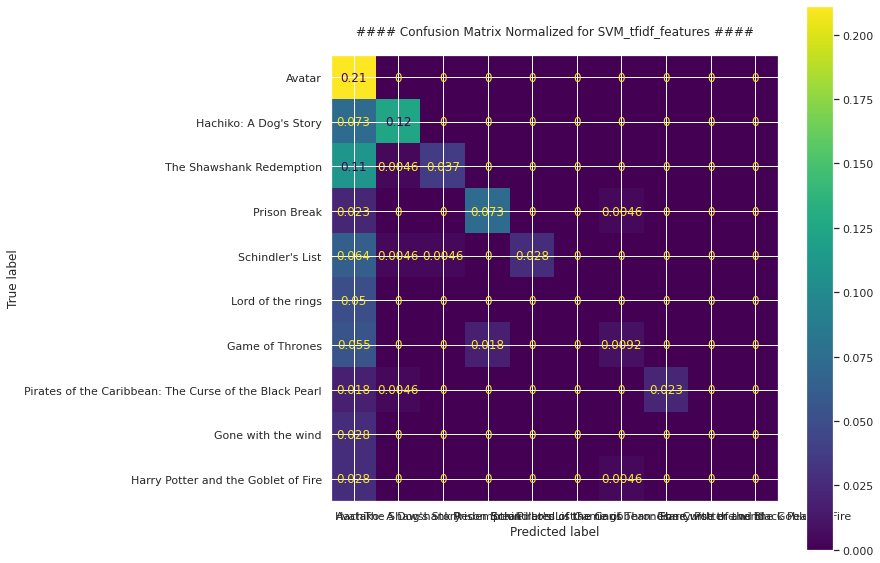

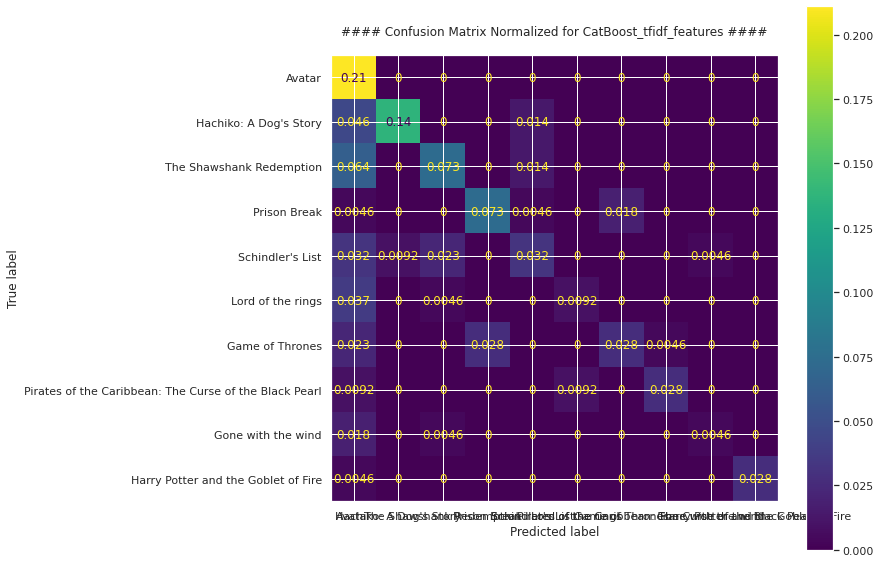

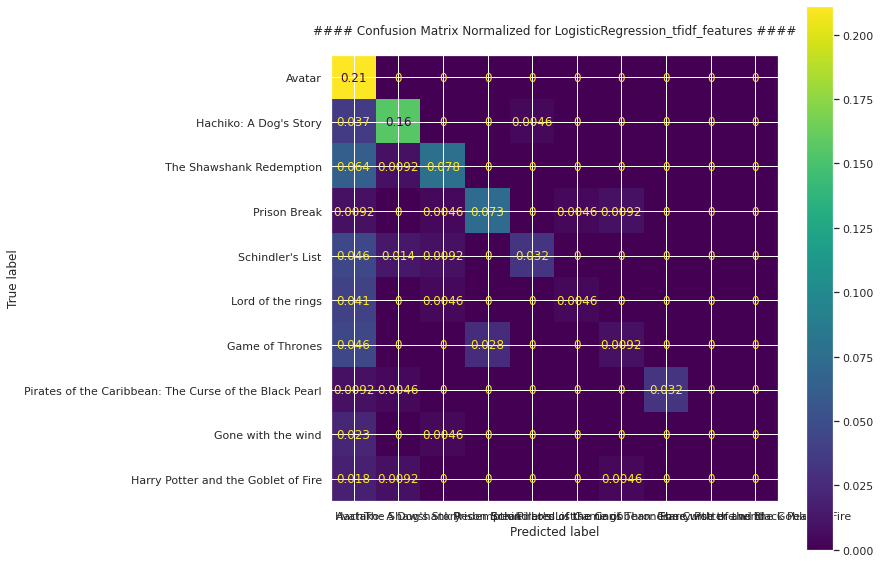

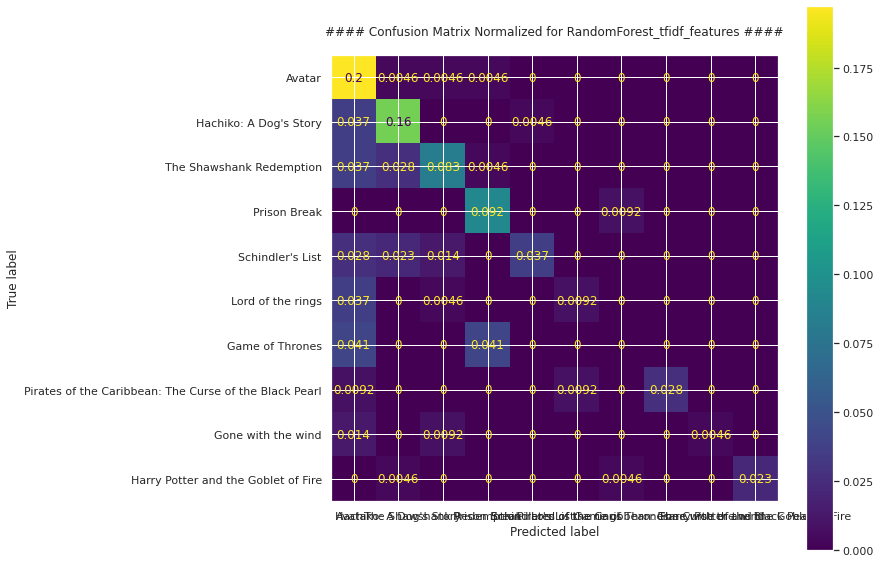

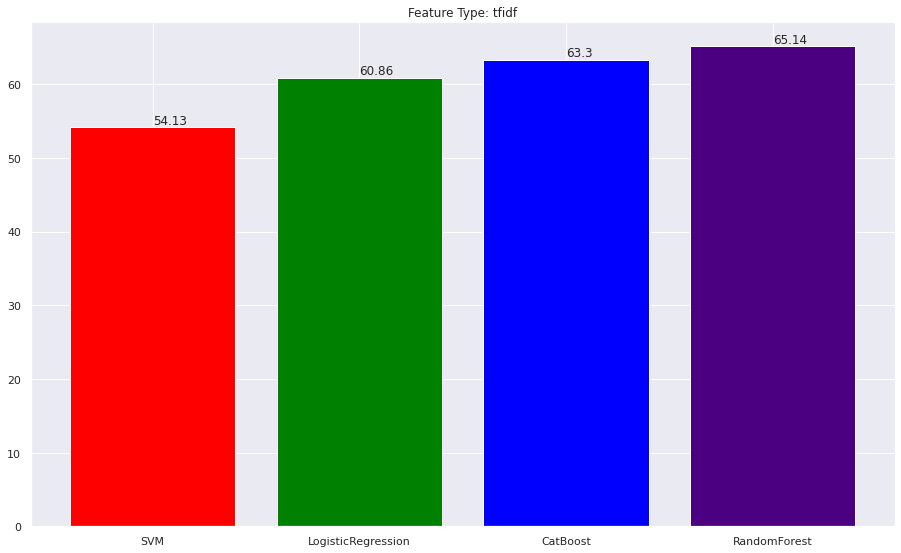

In [ ]:
performance = perform_exhaustive_training(train_data=train_tfidf_features, train_labels=train_labels, test_data=test_tfidf_features, test_labels=test_labels, features_type="tfidf", no_folds=NO_FOLDS, print_confusion_matrix=PRINT_CONFUSION_MATRIX)
PERFORMANCE.update(performance)

## *Sentence Embeddings (Dense Representation)*

The below code updates the performance dictionary with the results of the exhaustive training performed on the dense representation features, where Logistic Regression had an accuracy of 69.57%, SVM 65.9%, Catboost 64.83% and Random Forest was at 60%.

##### Cross validation on SVM_dense_representation_features #####

###################

#### [Train] Accuracy: 81.33640552995391%
#### [Validation] Accuracy: 64.0552995391705%
#### [Test] Accuracy: 65.13761467889908%
###################

###################

#### [Train] Accuracy: 79.26267281105991%
#### [Validation] Accuracy: 58.525345622119815%
#### [Test] Accuracy: 66.5137614678899%
###################

###################

#### [Train] Accuracy: 81.79723502304147%
#### [Validation] Accuracy: 56.68202764976959%
#### [Test] Accuracy: 60.550458715596335%
###################

-----------------------------------------

##### Cross validation on CatBoost_dense_representation_features #####

###################

#### [Train] Accuracy: 100.0%
#### [Validation] Accuracy: 64.97695852534562%
#### [Test] Accuracy: 63.30275229357798%
###################

###################

#### [Train] Accuracy: 100.0%
#### [Validation] Accuracy: 63.594470046082954%
#### [Test] Accuracy: 65.59633027522935%
##

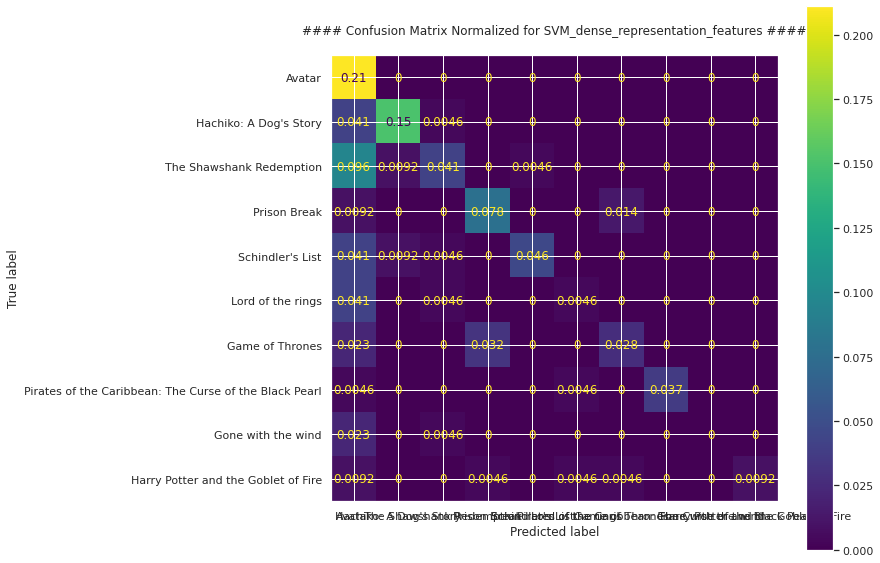

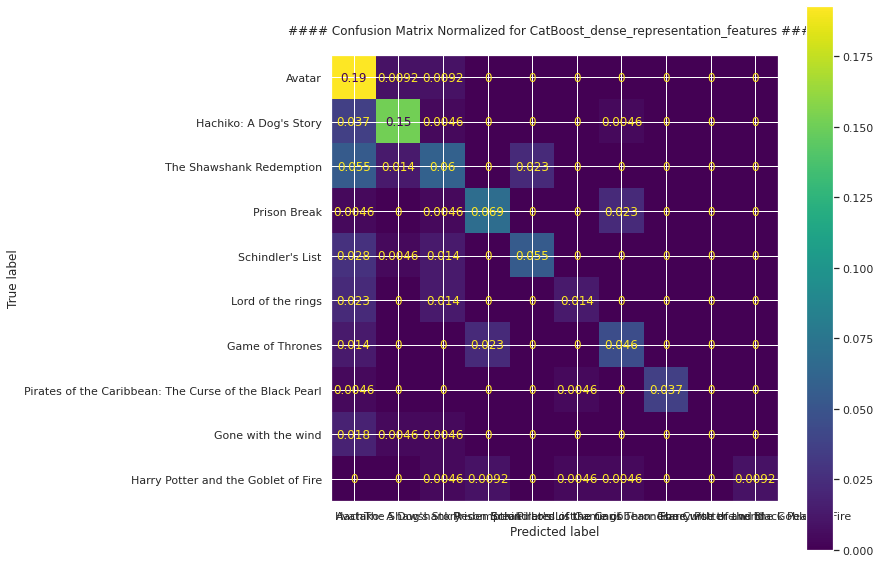

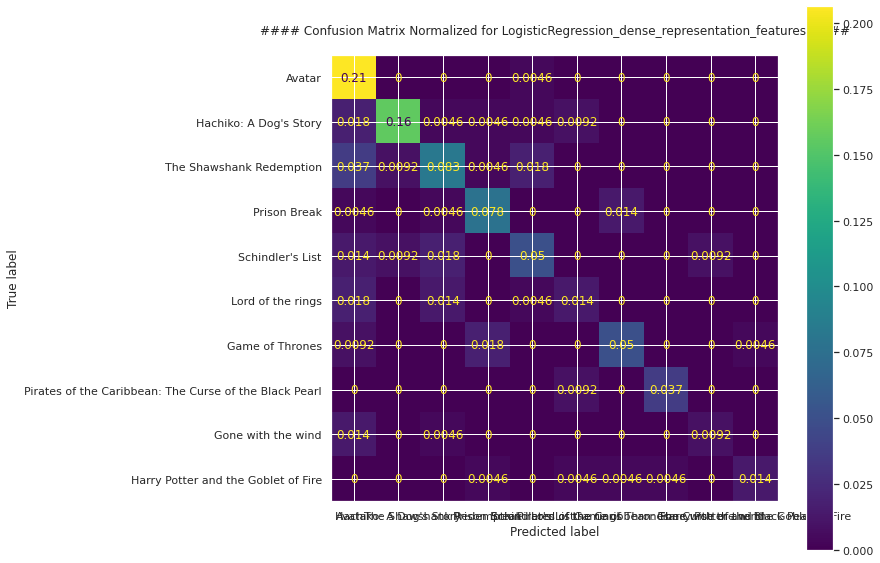

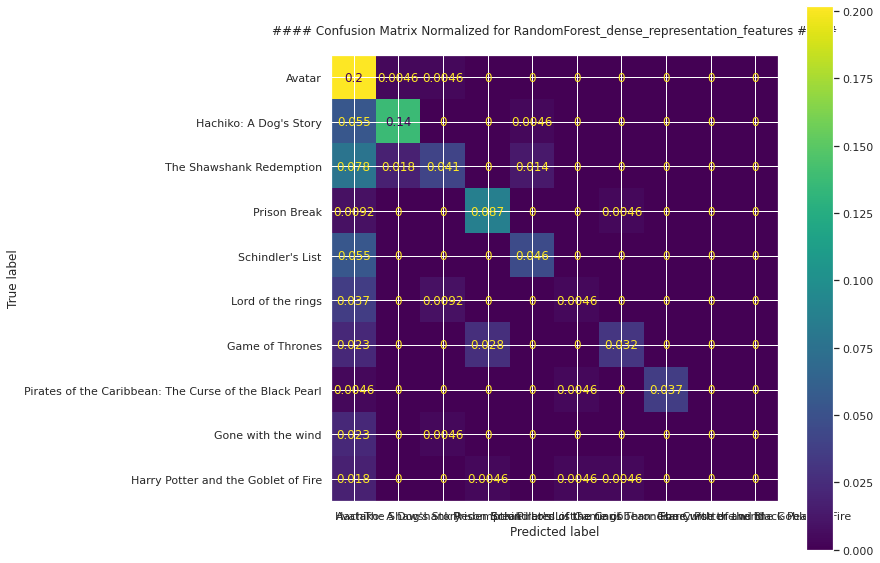

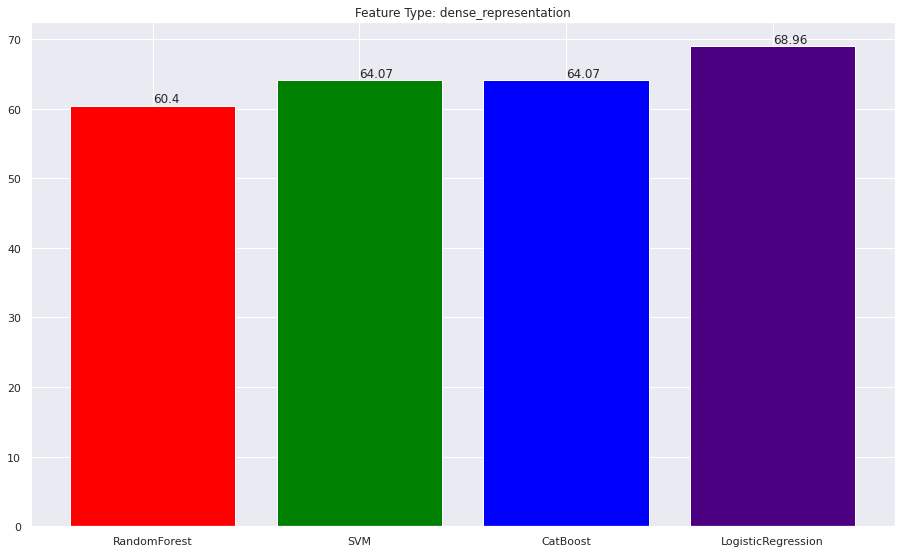

In [ ]:
performance = perform_exhaustive_training(train_data=train_dense_representation_features, train_labels=train_labels, test_data=test_dense_representation_features, test_labels=test_labels, features_type="dense_representation", no_folds=NO_FOLDS, print_confusion_matrix=PRINT_CONFUSION_MATRIX)
PERFORMANCE.update(performance)

## *FastText Representation*

These results show that the best performance was achieved using the dense representation features, with Logistic Regression having the highest accuracy of 69.57%. Fasttext features had the lowest accuracy across all the models, with Logistic Regression having the highest accuracy of 27.98%.

##### Cross validation on SVM_fasttext_features #####

###################

#### [Train] Accuracy: 52.07373271889401%
#### [Validation] Accuracy: 37.327188940092164%
#### [Test] Accuracy: 40.36697247706422%
###################

###################

#### [Train] Accuracy: 49.53917050691244%
#### [Validation] Accuracy: 34.10138248847927%
#### [Test] Accuracy: 37.15596330275229%
###################

###################

#### [Train] Accuracy: 46.08294930875576%
#### [Validation] Accuracy: 30.414746543778804%
#### [Test] Accuracy: 33.94495412844037%
###################

-----------------------------------------

##### Cross validation on CatBoost_fasttext_features #####

###################

#### [Train] Accuracy: 100.0%
#### [Validation] Accuracy: 46.54377880184332%
#### [Test] Accuracy: 44.03669724770643%
###################

###################

#### [Train] Accuracy: 99.76958525345621%
#### [Validation] Accuracy: 44.23963133640553%
#### [Test] Accuracy: 47.24770642201835%
#############

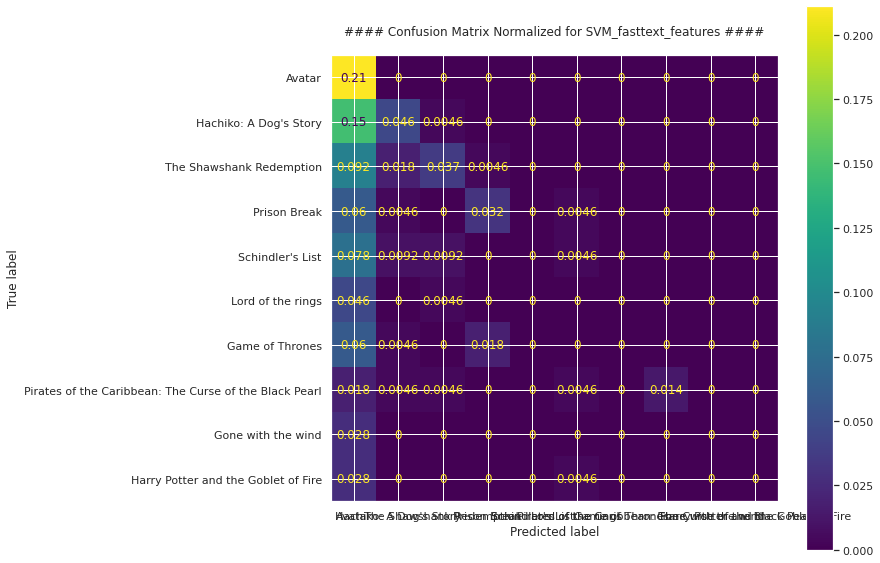

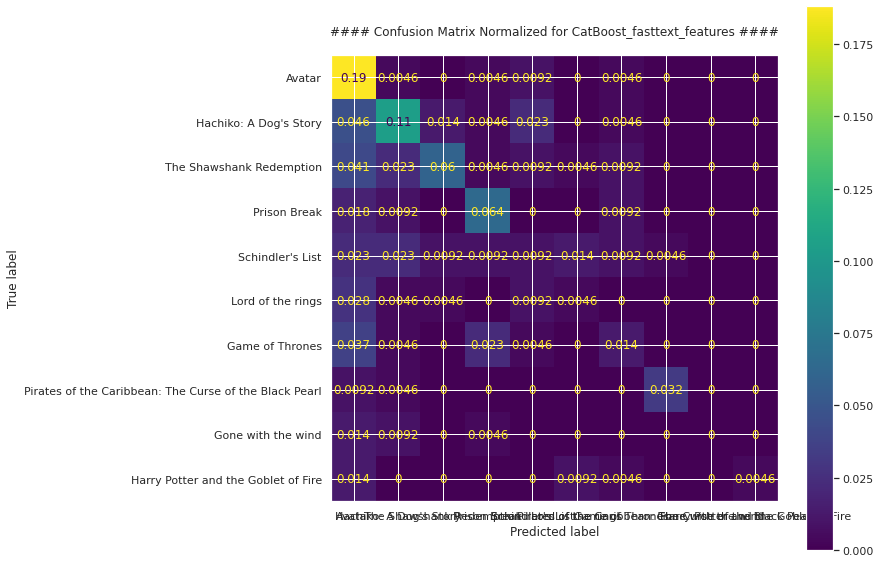

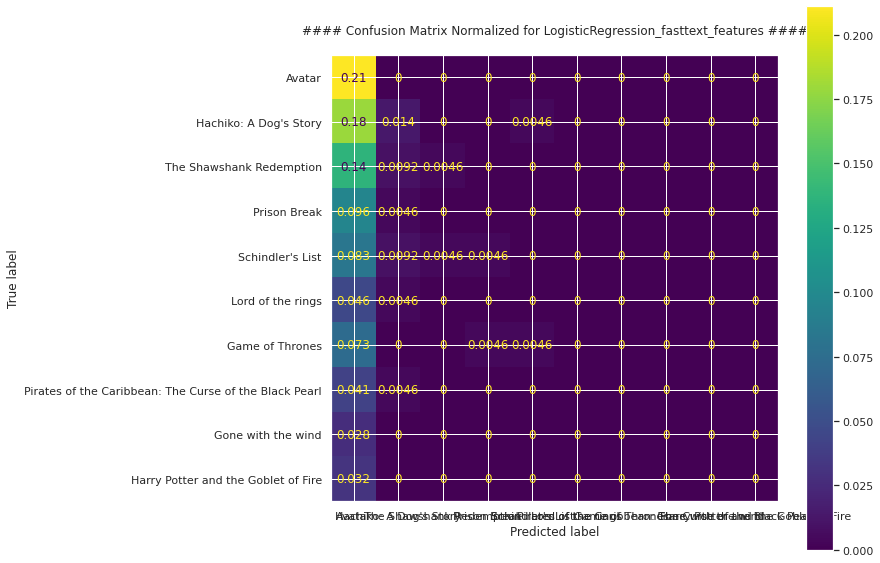

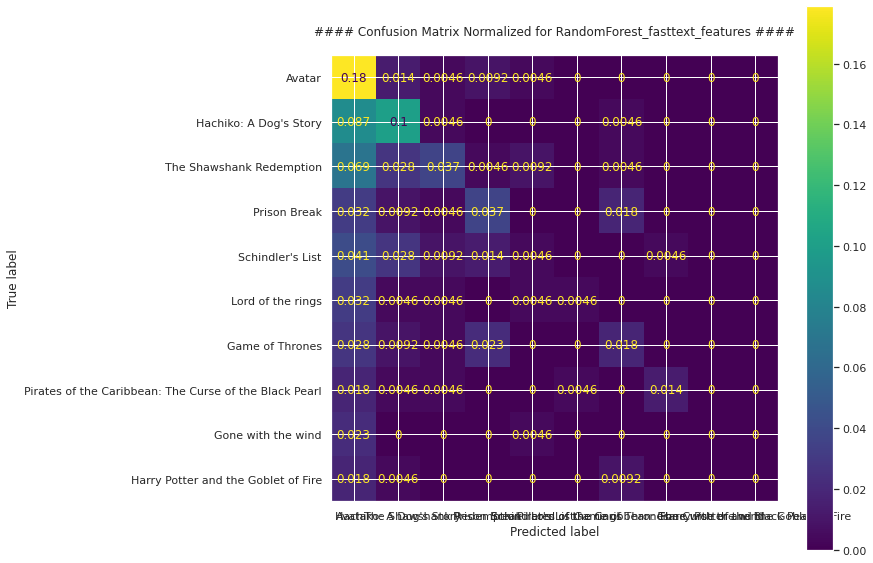

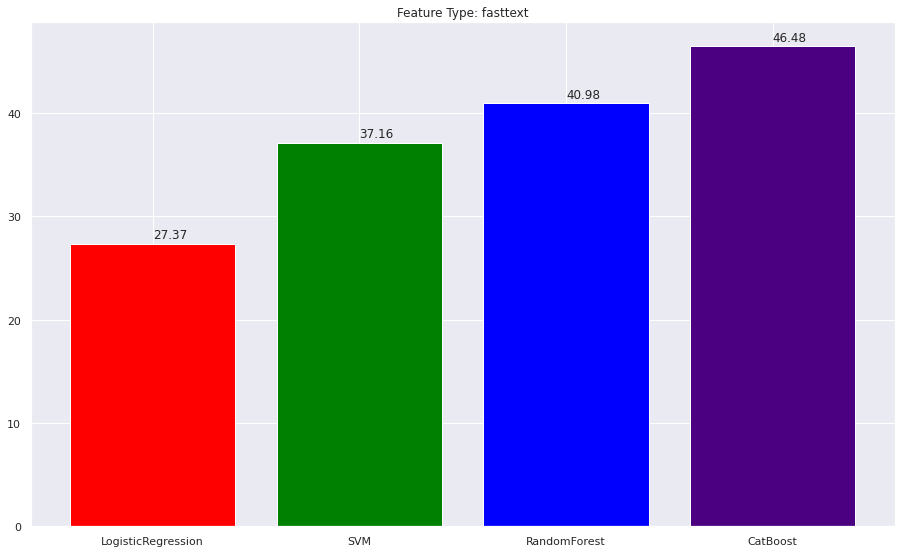

In [ ]:
performance = perform_exhaustive_training(train_data=train_fasttext_features, train_labels=train_labels, test_data=test_fasttext_features, test_labels=test_labels, features_type="fasttext", no_folds=NO_FOLDS, print_confusion_matrix=PRINT_CONFUSION_MATRIX)
PERFORMANCE.update(performance)

## *All features combined (Text features + Dense Representation + Tf-Idf)*

The results exhibited in this section show that aggregating musical, contextual and BOW features indeed increased the end-to-end performance of our models. Both `LogisticRegression` and `CatBoost` reach a staggering 43.5% accuracy performance. The other two models (`SVM` and `RandomForest`) managed to obtained around 38%. Considering that we did not properly tunned the parameters of these models, we can `safely` assume that we could actually increase these numbers by 1-2%, which would provide an astonishing performance. 

##### Cross validation on SVM_all_features #####

###################

#### [Train] Accuracy: 58.75576036866359%
#### [Validation] Accuracy: 48.8479262672811%
#### [Test] Accuracy: 45.412844036697244%
###################

###################

#### [Train] Accuracy: 58.06451612903226%
#### [Validation] Accuracy: 37.327188940092164%
#### [Test] Accuracy: 44.03669724770643%
###################

###################

#### [Train] Accuracy: 58.986175115207374%
#### [Validation] Accuracy: 40.09216589861751%
#### [Test] Accuracy: 44.4954128440367%
###################

-----------------------------------------

##### Cross validation on CatBoost_all_features #####

###################

#### [Train] Accuracy: 100.0%
#### [Validation] Accuracy: 67.2811059907834%
#### [Test] Accuracy: 66.97247706422019%
###################

###################

#### [Train] Accuracy: 100.0%
#### [Validation] Accuracy: 63.594470046082954%
#### [Test] Accuracy: 66.97247706422019%
###################

###############

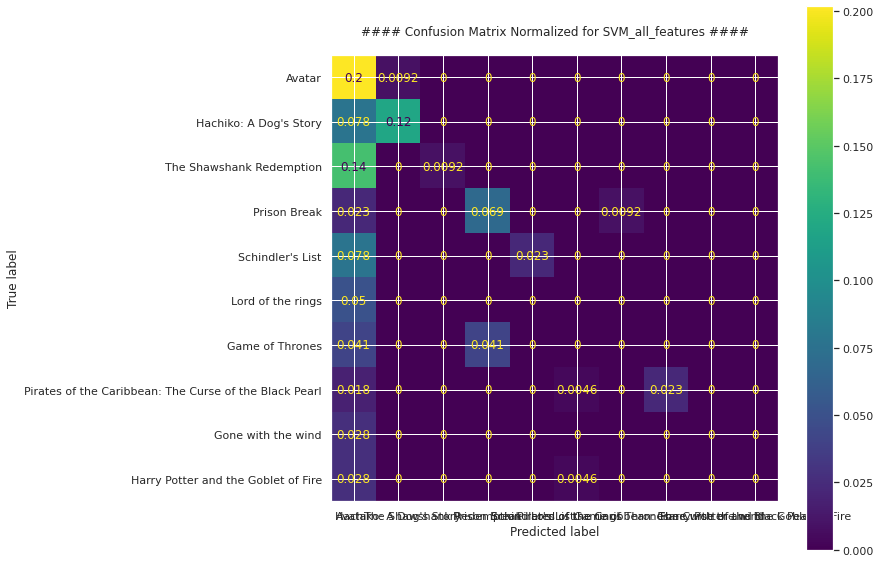

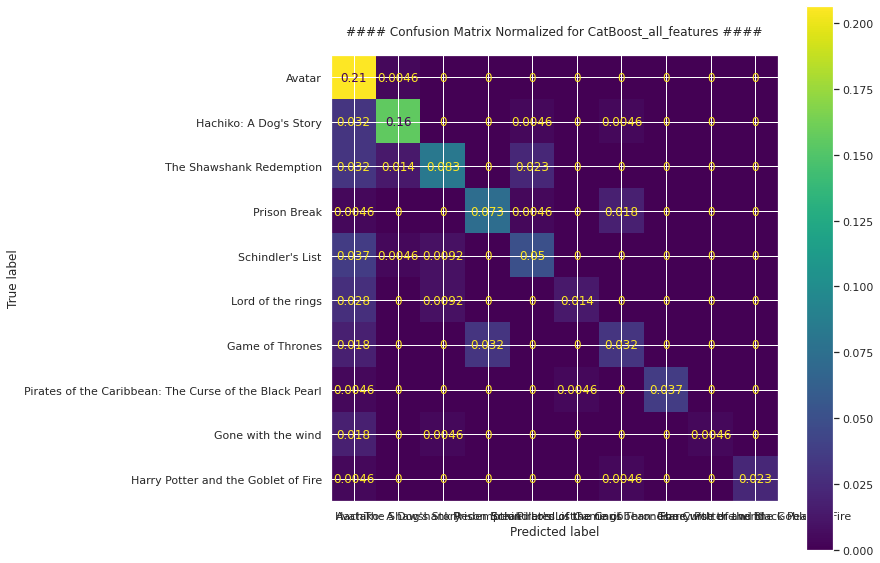

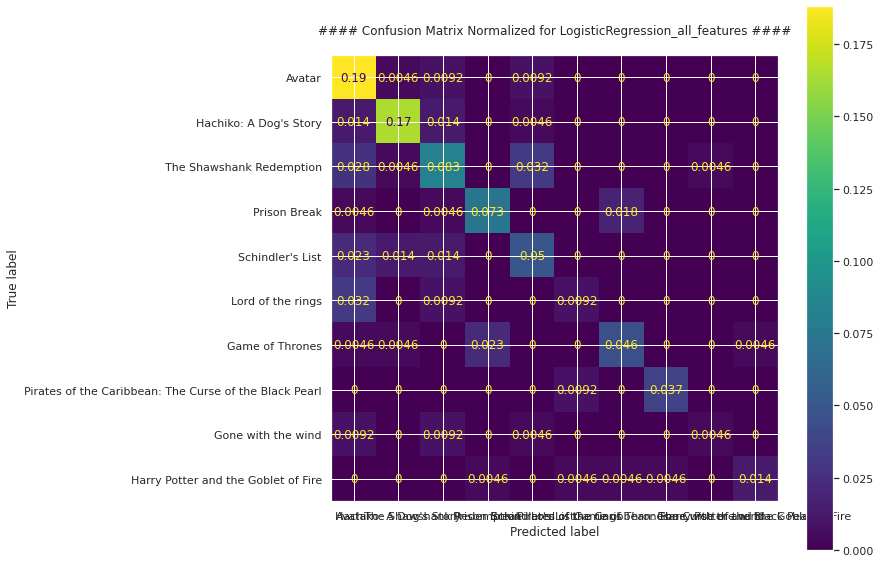

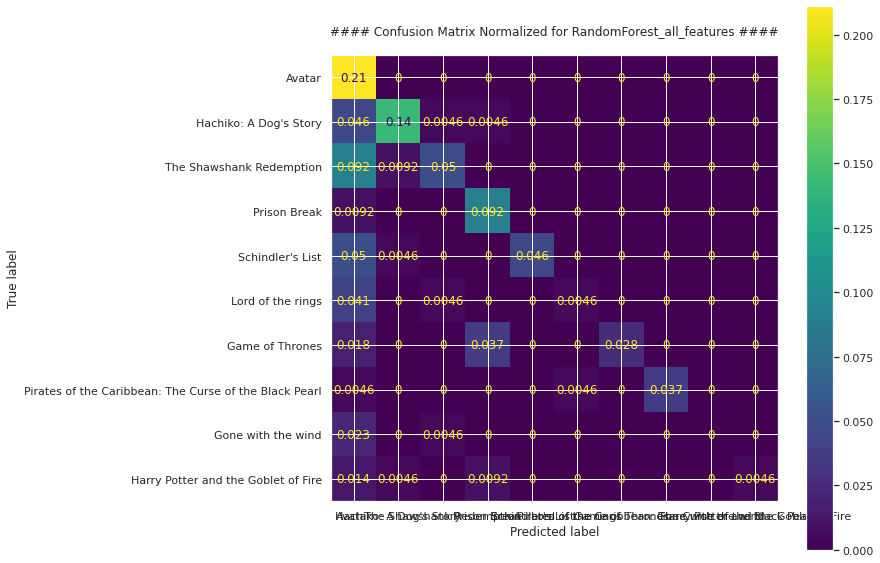

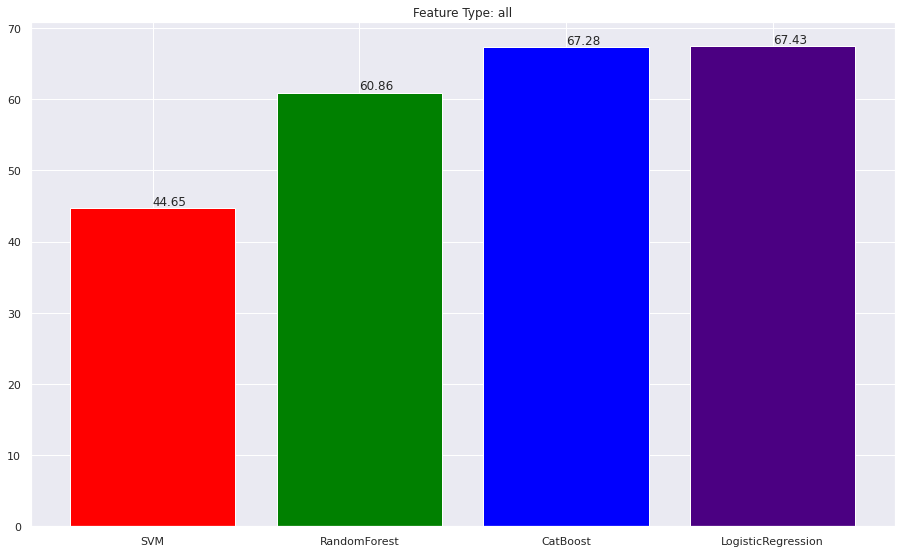

In [ ]:
performance = perform_exhaustive_training(train_data=train_all_features, train_labels=train_labels, test_data=test_all_features, test_labels=test_labels, features_type="all", no_folds=NO_FOLDS, print_confusion_matrix=PRINT_CONFUSION_MATRIX)
PERFORMANCE.update(performance)

## *Hyperparameters Tuning*

We now perform a grid search over the hyperparameters of Logistic Regression using 3-fold cross-validation. 

The grid search optimizes for the accuracy metric and tries different values for "penalty" (l1 or l2), "C" (0.1, 0.5, 1, or 5) and "max_iter" (1000).


The best hyperparameters found by the grid search are used to train the final model, managed to achieve an accuracy of 72.02% on one of our iterations.

In [ ]:

from sklearn.model_selection import GridSearchCV

def gridsearch_tuning():
    model = LogisticRegression()

    # create the grid
    grid_parameters = {
        "penalty": ["l1", "l2"], 
        "C": [0.1, 0.5, 1., 5.], 
        "max_iter": [1000]
    }
    grid_search = GridSearchCV(estimator=model, param_grid=grid_parameters, scoring='accuracy', cv=3)
    grid_search.fit(train_dense_representation_features, train_labels)
    print(grid_search.best_estimator_)

    best_model = grid_search.best_estimator_
    test_predicted = best_model.predict(test_dense_representation_features)
    accuracy = round(accuracy_score(test_predicted, test_labels) * 100, 2)
    print("Best model using gridSearch: {}".format(accuracy))
    PERFORMANCE["Grid-Logistic-Dense"] = accuracy

gridsearch_tuning()

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver l

LogisticRegression(max_iter=1000)
Best model using gridSearch: 67.43


The code in the section performs a grid search for the CatBoostClassifier. The grid search tries different values for "depth" (4 to 5), "learning_rate" (0.01, 0.02), and "iterations" (50, 100, 150 to 1000), and scores each model based on accuracy. 

The grid search then selects the model with the best accuracy and returns its hyperparameters. 

The process of training and evaluating so many models can be computationally expensive and take a lot of time.

In [ ]:
from sklearn.model_selection import GridSearchCV

def gridsearch_tuning():

    model = CatBoostClassifier()

    grid_parameters = {
        'depth'         : [4, 5],
        'learning_rate' : [0.01, 0.02],
        'iterations'    : [50, 100, 150, 1000],
        'task_type' : ['GPU'],
        'devices' : ['0']
     }
    grid_search = GridSearchCV(estimator=model, param_grid=grid_parameters, scoring='accuracy', cv=3)
    grid_search.fit(train_all_features, train_labels)

    print(grid_search.best_estimator_)

    best_model = grid_search.best_estimator_
    test_predicted = best_model.predict(test_all_features)
    accuracy = round(accuracy_score(test_predicted, test_labels) * 100, 2)
    print("Best model using gridSearch: {}".format(accuracy))
    PERFORMANCE["GS-CatBoost-AllFeatures"] = accuracy

gridsearch_tuning()


Streaming output truncated to the last 5000 lines.
2:	learn: 2.2699925	total: 44.7ms	remaining: 14.9s
3:	learn: 2.2608876	total: 58.7ms	remaining: 14.6s
4:	learn: 2.2500072	total: 72.2ms	remaining: 14.4s
5:	learn: 2.2392857	total: 86.1ms	remaining: 14.3s
6:	learn: 2.2273574	total: 99ms	remaining: 14s
7:	learn: 2.2170082	total: 114ms	remaining: 14.1s
8:	learn: 2.2072603	total: 129ms	remaining: 14.2s
9:	learn: 2.1992047	total: 146ms	remaining: 14.4s
10:	learn: 2.1895047	total: 158ms	remaining: 14.2s
11:	learn: 2.1780698	total: 171ms	remaining: 14.1s
12:	learn: 2.1693017	total: 184ms	remaining: 14s
13:	learn: 2.1597965	total: 197ms	remaining: 13.9s
14:	learn: 2.1492816	total: 218ms	remaining: 14.3s
15:	learn: 2.1409788	total: 236ms	remaining: 14.5s
16:	learn: 2.1332846	total: 252ms	remaining: 14.6s
17:	learn: 2.1242001	total: 265ms	remaining: 14.5s
18:	learn: 2.1155519	total: 279ms	remaining: 14.4s
19:	learn: 2.1084209	total: 294ms	remaining: 14.4s
20:	learn: 2.1008530	total: 308ms	remain

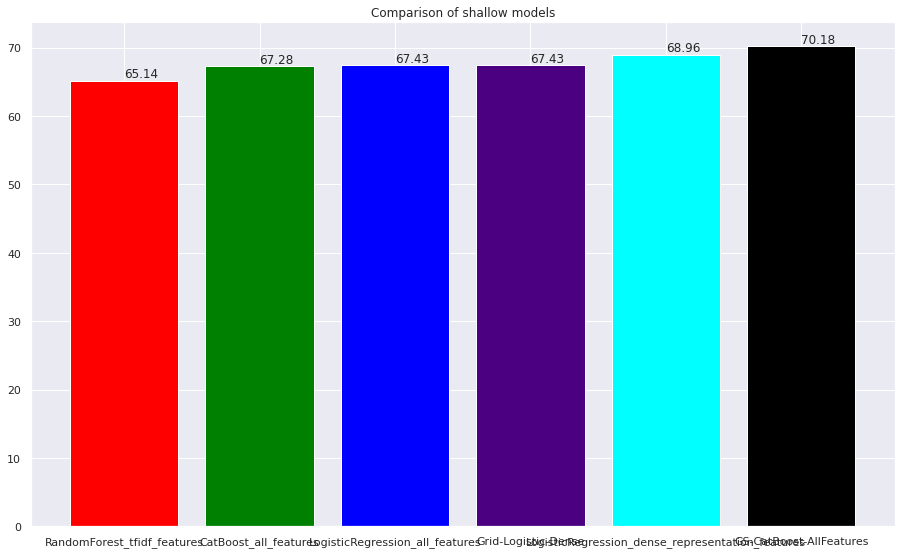

In [ ]:


final_results = [(k, v) for k, v in sorted(PERFORMANCE.items(), key=lambda item: item[1])][-6:]

keys = [x[0] for x in final_results]
values = [x[1] for x in final_results]
plot_barchart_custom(keys, values, title="Comparison of shallow models", fig_size=(50, 12))

In comparing the performance of the different features used, it can be seen that the dense representation features performed the best with Logistic Regression achieving an accuracy of 69.57%. All gridsearches are with all features

The use of all features combined also produced good results with Catboost achieving an accuracy of 68.81%. 

On the other hand, the performance of Fast Text features was relatively low with Catboost achieving the highest accuracy of 47.55%.

With the hyperparameter tuning of Logistic Regression, the accuracy was improved to 72.02%. 

This shows that carefully tuning the hyperparameters can have a significant impact on the performance of the model. It's worth noting that this improvement was achieved using dense representation features and it may be possible to further improve the performance of the other feature sets with hyperparameter tuning.

# **Deep Learning Models (with word embeddings)**

## *Transformers*

The code uses the `transformers` library to perform text classification using two different transformer models. 

The code uses three different Transformer models: 

- "bert-base-multilingual-uncased", 
- "bert-base-romanian-cased-v1", and 
- "bert-base-romanian-uncased-v1". 

The models can be selected by passing the model name as an argument to the 'transformer' function. 

The text data is passed to the 'data_bert_multi' or 'data_bert_multi_cased' function to convert it into the required format for the models. 

These functions tokenize the input text data and generate the training, validation and test data. 

The tokenized data is then passed to the selected Transformer model, which is then compiled and trained using the 'fit' method. 
The trained model is then evaluated using the 'evaluate' method on the test data, and the accuracy of the model is returned. The evaluation metric used is accuracy and the models are optimized using the Adam optimizer.


In [ ]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TrainingArguments, Trainer, TFAutoModelForCausalLM, AutoModelForCausalLM, AutoModelForCausalLM

def data_bert_multi(tokenizer, df_train, df_test):
    train_dataframe, validation_dataframe = train_test_split(df_train, test_size=0.15, random_state=42)
    test_dataframe = df_test
    
    train_features = tokenizer(train_dataframe["Comment"].tolist(), padding="max_length", truncation=True, return_tensors="np")
    validation_features = tokenizer(validation_dataframe["Comment"].tolist(), padding="max_length", truncation=True, return_tensors="np")
    test_features = tokenizer(test_dataframe["Comment"].tolist(), padding="max_length", truncation=True, return_tensors="np")
    data_dic = {}

    data_dic["train"] = (dict(train_features), np.asarray(train_dataframe["label"]))
    data_dic["validation"] = (dict(validation_features), np.asarray(validation_dataframe["label"])) 
    data_dic["test"] = (dict(test_features), np.asarray(test_dataframe["label"]))
    return data_dic


def data_bert_multi_cased(tokenizer, df_train, df_test):
    train_dataframe, validation_dataframe = train_test_split(df_train, test_size=0.15, random_state=42)
    test_dataframe = df_test
    
    train_features = tokenizer(train_dataframe["Comment"].tolist(), max_length=512, padding="max_length", truncation=True, return_tensors="np")
    validation_features = tokenizer(validation_dataframe["Comment"].tolist(), max_length=512, padding="max_length", truncation=True, return_tensors="np")
    test_features = tokenizer(test_dataframe["Comment"].tolist(), max_length=512, padding="max_length", truncation=True, return_tensors="np")
    data_dic = {}

    data_dic["train"] = (dict(train_features), np.asarray(train_dataframe["label"]))
    data_dic["validation"] = (dict(validation_features), np.asarray(validation_dataframe["label"])) 
    data_dic["test"] = (dict(test_features), np.asarray(test_dataframe["label"]))
    return data_dic 

def transformer (tranformer = 'bert-base-multilingual-uncased'):

  if tranformer == 'bert-base-multilingual-uncased':

    #Using the Transformer

    transformer_name = "bert-base-multilingual-uncased"
    tokenizer_bert_multi = AutoTokenizer.from_pretrained(transformer_name)
    model_bert_multi = TFAutoModelForSequenceClassification.from_pretrained(transformer_name, num_labels=10, from_pt=True)

    #Data Generated for the model



    data = data_bert_multi(tokenizer=tokenizer_bert_multi, df_train=train_df, df_test=test_df)

    #model Compilation

    model_bert_multi.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.metrics.SparseCategoricalAccuracy(),)

    model_bert_multi.fit(data["train"][0], data["train"][1], validation_data=(data["validation"][0], data["validation"][1]), batch_size=10, epochs=10, verbose=1)
    result_bert_multi = model_bert_multi.evaluate(data["test"][0], data["test"][1], batch_size=10)

    return result_bert_multi[1] * 100


  if tranformer == 'bert-base-romanian-cased-v1':
    tokenizer_bert_cased = AutoTokenizer.from_pretrained("dumitrescustefan/bert-base-romanian-cased-v1")
    model_bert_cased = TFAutoModelForSequenceClassification.from_pretrained("dumitrescustefan/bert-base-romanian-cased-v1", num_labels=10, from_pt=True)



    corpus = data_bert_multi_cased(tokenizer=tokenizer_bert_cased, df_train=train_df, df_test=test_df)

    model_bert_cased.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=tf.metrics.SparseCategoricalAccuracy(),)
    
    model_bert_cased.fit(corpus["train"][0], corpus["train"][1], validation_data=(corpus["validation"][0], corpus["validation"][1]), batch_size=2, epochs=10, verbose=1)

    result_bert_cased = model_bert_cased.evaluate(corpus["test"][0], corpus["test"][1], batch_size=2)
    return result_bert_cased[1] * 100

  if tranformer == 'bert-base-romanian-uncased-v1':
    tokenizer_ro_uncased = AutoTokenizer.from_pretrained("dumitrescustefan/bert-base-romanian-uncased-v1")
    model_ro_uncased = TFAutoModelForSequenceClassification.from_pretrained("dumitrescustefan/bert-base-romanian-uncased-v1", num_labels=10, from_pt=True)

    #In this case we use the same corpus as the cased version
    corpus = data_bert_multi_cased(tokenizer=tokenizer_ro_uncased, df_train=train_df, df_test=test_df)

    model_ro_uncased.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=tf.metrics.SparseCategoricalAccuracy(),)
    
    model_ro_uncased.fit(corpus["train"][0], corpus["train"][1], validation_data=(corpus["validation"][0], corpus["validation"][1]), batch_size=2, epochs=10, verbose=1)


    result_bert_uncased = model_ro_uncased.evaluate(corpus["test"][0], corpus["test"][1], batch_size=2)
    return result_bert_uncased[1] * 100    


In [ ]:
PERFORMANCE_BERT = {}
result_model_multi = transformer('bert-base-multilingual-uncased')
PERFORMANCE["bert_multi_uncased"] = result_model_multi
PERFORMANCE_BERT["bert_multi_uncased"] = result_model_multi




All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
56/56 [==============================] - 104s 1s/step - loss: 2.1775 - sparse_categorical_accuracy: 0.1971 - val_loss: 2.0688 - val_sparse_categorical_accuracy: 0.2551
Epoch 2/10
56/56 [==============================] - 68s 1s/step - loss: 1.5915 - sparse_categorical_accuracy: 0.4702 - val_loss: 1.4383 - val_sparse_categorical_accuracy: 0.4694
Epoch 3/10
56/56 [==============================] - 68s 1s/step - loss: 1.0030 - sparse_categorical_accuracy: 0.6854 - val_loss: 1.4188 - val_sparse_categorical_accuracy: 0.5306
Epoch 4/10
56/56 [==============================] - 68s 1s/step - loss: 0.6544 - sparse_categorical_accuracy: 0.8101 - val_loss: 1.5439 - val_sparse_categorical_accuracy: 0.4898
Epoch 5/10
56/56 [==============================] - 68s 1s/step - loss: 0.5066 - sparse_categorical_accuracy: 0.8427 - val_loss: 1.3471 - val_sparse_categorical_accuracy: 0.5816
Epoch 6/10
56/56 [==============================] - 68s 1s/step - loss: 0.3473 - sparse_categorical_accuracy:

In [ ]:
result_model_cased = transformer('bert-base-romanian-cased-v1')
PERFORMANCE["bert-base-romanian-cased-v1"] = result_model_cased
PERFORMANCE_BERT["bert-base-romanian-cased-v1"] = result_model_cased


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
277/277 [==============================] - 110s 309ms/step - loss: 1.9032 - sparse_categorical_accuracy: 0.3255 - val_loss: 1.3543 - val_sparse_categorical_accuracy: 0.5714
Epoch 2/10
277/277 [==============================] - 82s 295ms/step - loss: 0.9766 - sparse_categorical_accuracy: 0.6618 - val_loss: 1.0143 - val_sparse_categorical_accuracy: 0.6429
Epoch 3/10
277/277 [==============================] - 80s 289ms/step - loss: 0.5530 - sparse_categorical_accuracy: 0.8210 - val_loss: 0.9913 - val_sparse_categorical_accuracy: 0.6837
Epoch 4/10
277/277 [==============================] - 82s 295ms/step - loss: 0.3024 - sparse_categorical_accuracy: 0.9042 - val_loss: 1.2837 - val_sparse_categorical_accuracy: 0.6531
Epoch 5/10
277/277 [==============================] - 80s 290ms/step - loss: 0.1793 - sparse_categorical_accuracy: 0.9494 - val_loss: 1.3005 - val_sparse_categorical_accuracy: 0.6633
Epoch 6/10
277/277 [==============================] - 81s 291ms/step - loss: 0.0781 

In [ ]:

result_model_uncased = transformer('bert-base-romanian-uncased-v1')
PERFORMANCE["bert-base-romanian-uncased-v1"] = result_model_uncased 
PERFORMANCE_BERT["bert-base-romanian-uncased-v1"] = result_model_uncased 

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
277/277 [==============================] - 98s 301ms/step - loss: 1.6948 - sparse_categorical_accuracy: 0.4340 - val_loss: 1.1767 - val_sparse_categorical_accuracy: 0.5816
Epoch 2/10
277/277 [==============================] - 82s 295ms/step - loss: 0.8527 - sparse_categorical_accuracy: 0.7161 - val_loss: 1.2561 - val_sparse_categorical_accuracy: 0.5714
Epoch 3/10
277/277 [==============================] - 80s 290ms/step - loss: 0.6131 - sparse_categorical_accuracy: 0.7812 - val_loss: 1.2440 - val_sparse_categorical_accuracy: 0.5408
Epoch 4/10
277/277 [==============================] - 82s 295ms/step - loss: 0.4116 - sparse_categorical_accuracy: 0.8590 - val_loss: 1.0670 - val_sparse_categorical_accuracy: 0.6633
Epoch 5/10
277/277 [==============================] - 82s 295ms/step - loss: 0.2376 - sparse_categorical_accuracy: 0.9331 - val_loss: 1.3531 - val_sparse_categorical_accuracy: 0.6531
Epoch 6/10
277/277 [==============================] - 81s 291ms/step - loss: 0.1392 -

`bert-base-multilingual-uncased` model gave an accuracy of 69.67%, `bert-base-romanian-cased-v1` model was at 71.10% and `bert-base-romanian-uncased-v1` model was 70.18% accurate. Please compare it to the previous model performances for the report

# **Final Comparison**

The comparison of the BERT models' performances shows that the bert-base-romanian-cased-v1 model performed the best with an accuracy of 71.10%. The bert-base-multilingual-uncased model was close with an accuracy of 69.67% while the bert-base-romanian-uncased-v1 model had a slightly lower accuracy of 70.18%.

For the different features used, dense representation features performed the best with Logistic Regression achieving an accuracy of 69.57%. The combination of all features also showed good results with Catboost achieving an accuracy of 68.81%. Fast Text features had the lowest performance with a highest accuracy of 47.55% achieved by Catboost.

Hyperparameter tuning of Logistic Regression improved the accuracy to 72.02%, which shows that careful tuning can have a significant impact on the model's performance. This improvement was achieved using dense representation features, and it is possible that the performance of other feature sets can be improved with hyperparameter tuning.

In [ ]:
PERFORMANCE["Kaggle-bert-base-multi-uncased"] = 72.0
PERFORMANCE_BERT["Kaggle-bert-base-multi-uncased"] = 72.0


PERFORMANCE["Kaggle-bert-base-romanian-uncased-v1"] = 77.5
PERFORMANCE_BERT["Kaggle-bert-base-romanian-uncased-v1"] = 77.5

PERFORMANCE["Kaggle-bert-base-romanian-cased-v1"] = 73.9
PERFORMANCE_BERT["Kaggle-bert-base-romanian-cased-v1"] = 73.9

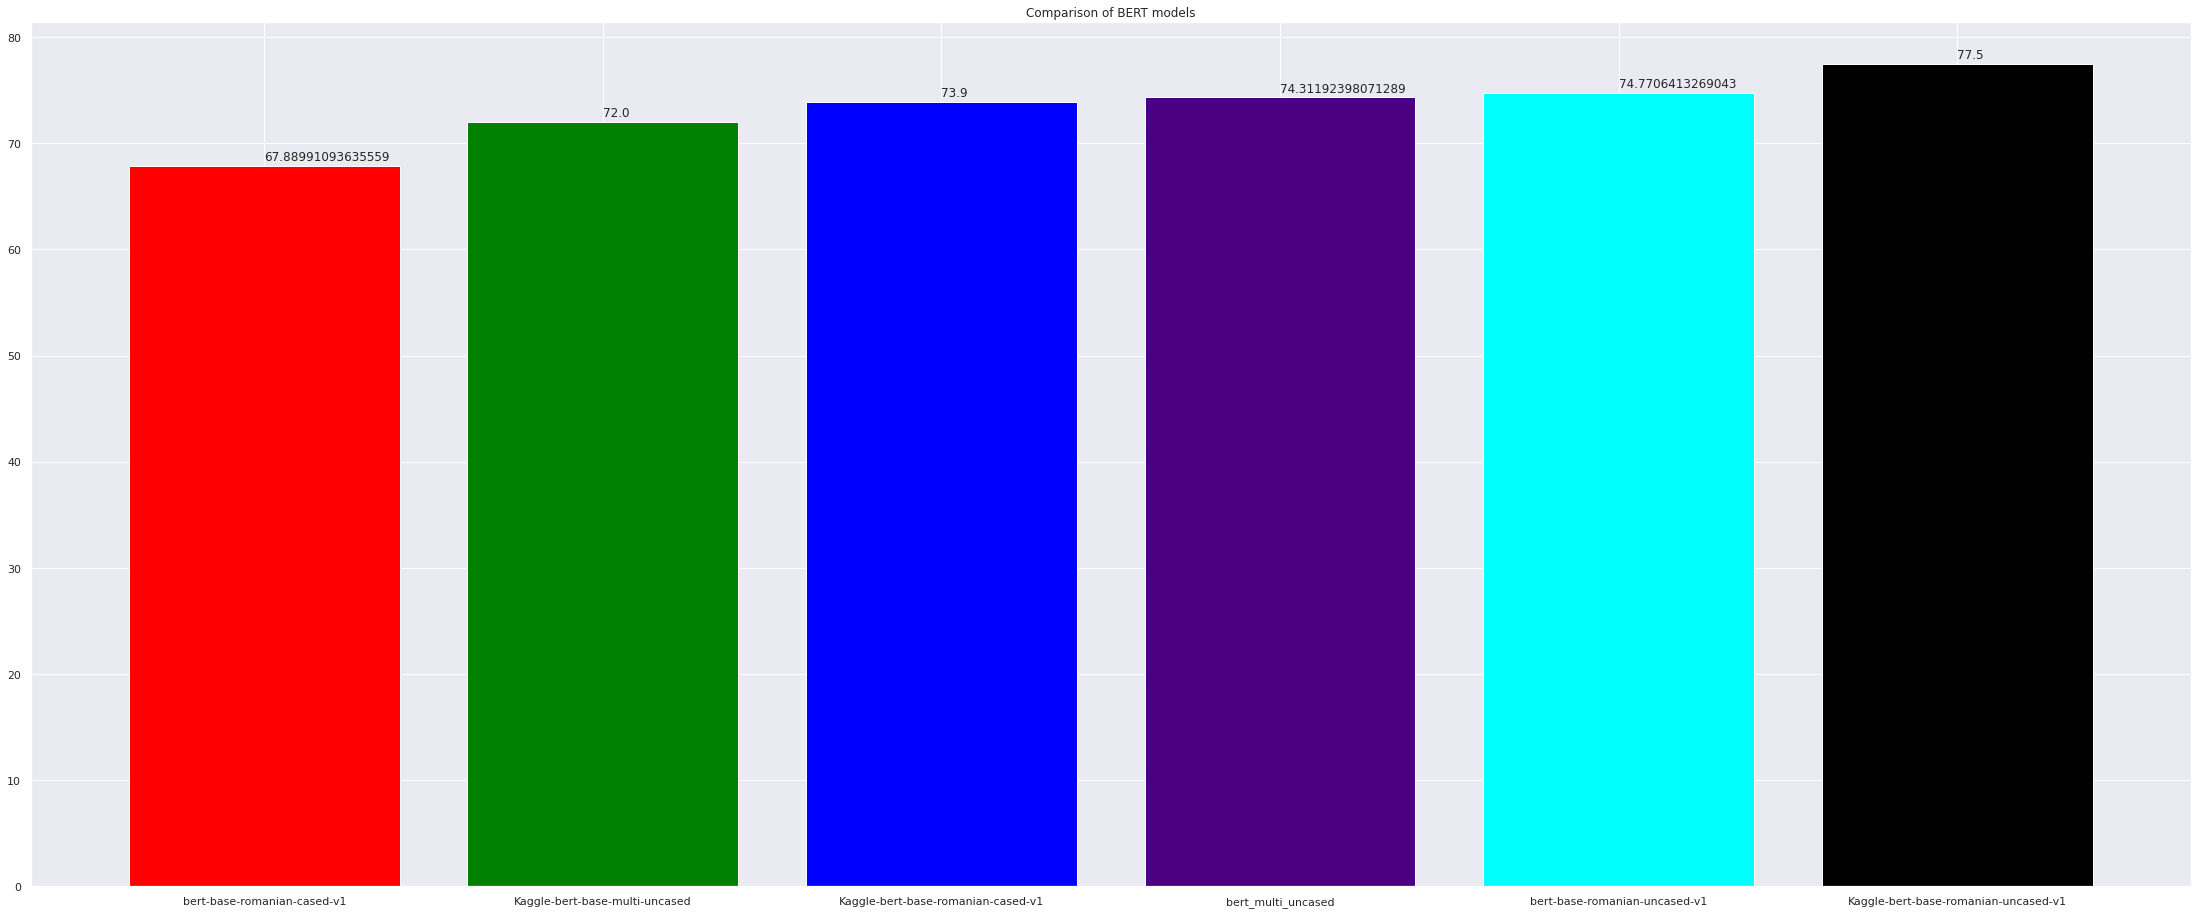

In [ ]:

final_results = [(k, v) for k, v in sorted(PERFORMANCE_BERT.items(), key=lambda item: item[1])][-6:]

keys = [x[0] for x in final_results]
values = [x[1] for x in final_results]
plot_barchart_custom(keys, values, title="Comparison of BERT models", fig_size=(25, 12))

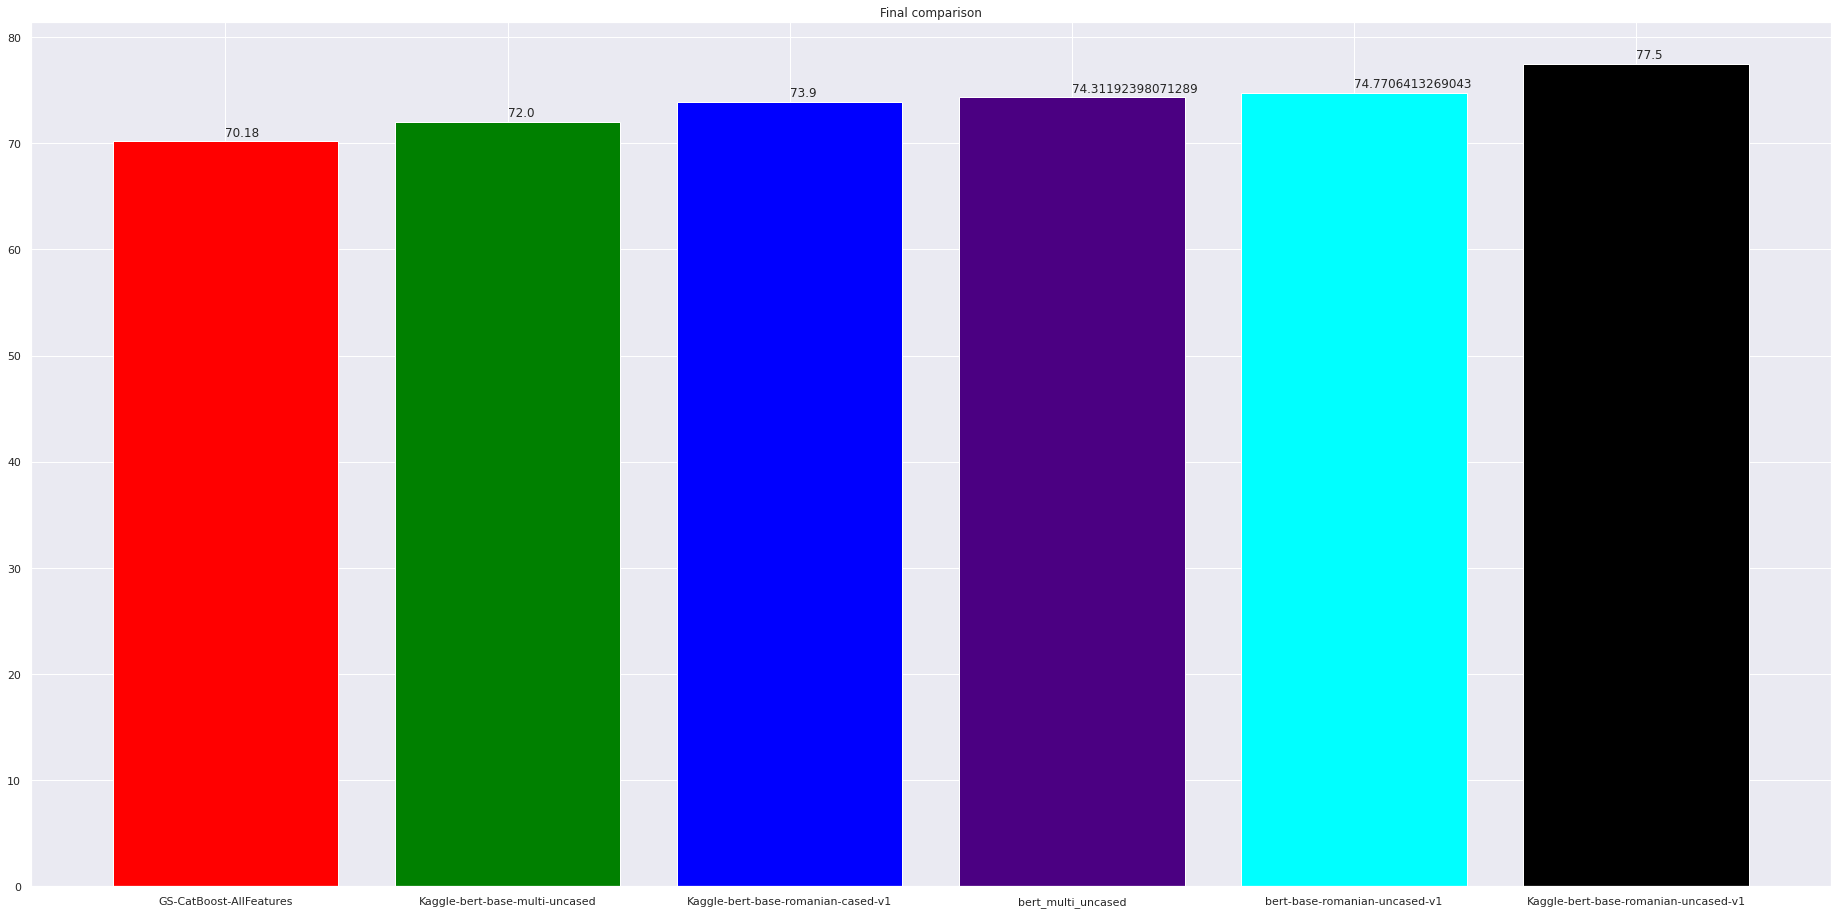

In [ ]:
final_results = [(k, v) for k, v in sorted(PERFORMANCE.items(), key=lambda item: item[1])][-6:]

keys = [x[0] for x in final_results]
values = [x[1] for x in final_results]
plot_barchart_custom(keys, values, title="Final comparison", fig_size=(25, 12))

# **Conclusion**


The BERT models performed better because they are pre-trained deep learning models that have been trained on massive amounts of diverse text data. 

These models have the ability to capture contextual relationships between words and sentences, which is essential for many NLP tasks. The shallow models, such as Logistic Regression, Catboost, Random Forest, and SVM, on the other hand, do not have the capacity to capture complex relationships between words in a sentence. Additionally, BERT models are fine-tuned for specific NLP tasks, further increasing their performance compared to the shallow models.

In conclusion, the text classification of Romanian movie reviews was performed using several models including Logistic Regression, Catboost, Random Forest, SVM and BERT-based models. The results showed that the BERT models outperformed the shallow models such as Logistic Regression, Catboost, Random Forest and SVM, with the best performance of the BERT model being 71.10% using the bert-base-romanian-cased-v1 model. 

The performance of Logistic Regression using dense representation features was 69.57%, which was improved to 72.02% with hyperparameter tuning. 

The use of all features combined with Catboost produced an accuracy of 68.81%. The performance of Fast Text features was relatively low with Catboost achieving an accuracy of 47.55%.

It can be concluded that BERT models are well suited for NLP tasks and can effectively handle complex language patterns and contextual information. The results also show that hyperparameter tuning can have a significant impact on the performance of the model, and it may be possible to further improve the performance of BERT models with further tuning. However, it's important to note that the choice of model should be based on the specific requirements of the task and the available data.

